# команда - ЭНД
# Участники: Оспанов Әділхан и Қазбек Ильяс
# Университет - Максут Нарикбаев Университет (МНУ)

Для сегментации покупателей мы применили комплексный подход, начиная с глубокой предобработки транзакционных данных. Этот этап включал извлечение временных признаков, агрегацию поведенческих метрик и категориальных трат по каждому клиенту, что позволило сформировать до 100 производных переменных и создать детальный профиль каждого пользователя.

Построение графовой нейронной сети и кластеризация
для выявления скрытых связей и создания более информативных представлений клиентов был построен граф с использованием KNN. Затем мы применили графовую нейронную сеть (GNN), в частности Graph Autoencoder с GATConv, для генерации высококачественных эмбеддингов. На основе полученных эмбеддингов была проведена кластеризация с помощью DBSCAN и HDBSCAN. Это позволило выявить 4-5 четких и хорошо дифференцированных сегментов покупателей. Каждый сегмент был детально проинтерпретирован с помощью описательной статистики по всем аспектам поведения, что дало ценные инсайты для персонализации продуктов и маркетинговых стратегий.

Оценка перформанса моделей
Производительность моделей измерялась с использованием внутренних метрик кластеризации, таких как Silhouette Score, Calinski-Harabasz Index и Davies-Bouldin Index. Эти метрики крайне важны для кластеризации без учителя, так как у нас отсутствуют заранее известные "правильные" ответы. Они оценивают качество кластеров, опираясь исключительно на внутреннюю структуру данных.

Silhouette Score оценивает, насколько хорошо объект соответствует своему кластеру и отличается от соседних кластеров.
Calinski-Harabasz Index измеряет отношение межкластерной дисперсии к внутрикластерной, что характеризует разделение и плотность кластеров.
Davies-Bouldin Index показывает среднее сходство между кластером и его наиболее похожим кластером, при этом низкие значения указывают на хорошую кластеризацию.
Совместное использование этих метрик позволило объективно оценить, насколько чётко и осмысленно модель сгруппировала данные. В итоге, мы выбрали наилучшие модели, основанные на DBSCAN и HDBSCAN, которые успешно выделили более трёх кластеров. Spectral Clustering не показал удовлетворительных результатов и был исключен из дальнейшего анализа.

Содержание:



1.   Создание признаков на уровне клиента
2.   Создание признаков на основе сводных таблиц
3.   Обработка данных
4.   HDBSCAN на основе эмбеддингов, полученных с помощью графовых нейронных сетей (GAT)
4.   Финальное описание кластеров клиентов по HDBSCAN
6.   Создаем графики и дескриптив статистику по кластерам для HDBSCAN
7.   DBSCAN на основе эмбеддингов, полученных с помощью графовых нейронных сетей (GAT)
8.   Финальное описание кластеров клиентов по DBSCAN
7.   Создаем графики и дескриптив статистику по кластерам для DBSCAN
8.   Spectral Clustering на основе эмбеддингов, полученных с помощью графовых нейронных сетей (GAT)






In [ ]:
!pip install torch_geometric
!pip install faiss-cpu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GAE, GCNConv

import faiss
import umap
import hdbscan
import os
import random


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 49.2 MB/s eta 0:00:00


In [ ]:
initial_df = pd.read_parquet("/content/DECENTRATHON_3.0.parquet")

# Установка seed
seed_value = 42

# Python встроенный генератор
random.seed(seed_value)

# NumPy
np.random.seed(seed_value)

# PyTorch
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)


In [ ]:
df = initial_df

В данном этапе анализа были рассчитаны средние интервалы времени между транзакциями для каждой карты. Сначала временные метки транзакций были преобразованы в формат datetime, после чего определены минимальная и максимальная даты в выборке. Далее данные были отсортированы по идентификатору карты и времени транзакции, чтобы корректно рассчитать временные различия между последовательными транзакциями. Затем для каждой карты было вычислено среднее значение этих интервалов, что позволило получить показатель avg_time_between_txn, характеризующий поведенческую активность клиентов.

In [ ]:
df['transaction_timestamp'] = pd.to_datetime(df['transaction_timestamp'])

# Find the earliest date
earliest = df['transaction_timestamp'].min()
print("Earliest: ",earliest)
# Find the latest date
latest = df['transaction_timestamp'].max()
print('Latest: ' ,latest)
df = df.sort_values(by=['card_id', 'transaction_timestamp'])

# Вычисляем разницу во времени между транзакциями (в секундах)
df['time_diff'] = df.groupby('card_id')['transaction_timestamp'].diff().dt.total_seconds()

# Среднее время между транзакциями по карте
avg_time_diff = df.groupby('card_id')['time_diff'].mean().reset_index()
avg_time_diff.columns = ['card_id', 'avg_time_between_txn']

Earliest:  2023-01-01 00:30:12.551745
Latest:  2024-12-31 23:59:35.437993


### Создание признаков на уровне клиента (card_id)

- Извлечение из временной метки дня недели, месяца и часа транзакции.
- Сортировка транзакций по клиенту и времени.
- Расчет среднего времени между транзакциями для каждого клиента (`avg_time_between_txn`).
- Вычисление доли зарубежных операций (`share_foreign_txn`), где страна эквайера не равна 'KAZ'.
- Определение доли операций с конверсией валюты (`share_converted_txn`).
- Объединение всех признаков в один датафрейм `features` по `card_id`.


In [ ]:
df['day_name'] = df['transaction_timestamp'].dt.day_name()
df['month_name'] = df['transaction_timestamp'].dt.month_name()
df['hour'] = df['transaction_timestamp'].dt.hour


df = df.sort_values(by=['card_id', 'transaction_timestamp'])
df['time_diff'] = df.groupby('card_id')['transaction_timestamp'].diff().dt.total_seconds()
avg_time_diff = df.groupby('card_id')['time_diff'].mean().reset_index()
avg_time_diff.columns = ['card_id', 'avg_time_between_txn']

# 🌍 Доля операций за границей
df['is_foreign'] = (df['acquirer_country_iso'] != 'KAZ').astype(int)
foreign_txn_share = df.groupby('card_id')['is_foreign'].mean().reset_index()
foreign_txn_share.columns = ['card_id', 'share_foreign_txn']

# 💱 Доля операций с конверсией
df['is_converted'] = df['original_amount'].notna().astype(int)
conversion_share = df.groupby('card_id')['is_converted'].mean().reset_index()
conversion_share.columns = ['card_id', 'share_converted_txn']

# 🔗 Объединяем все фичи по card_id
features = avg_time_diff \
    .merge(foreign_txn_share, on='card_id', how='left') \
    .merge(conversion_share, on='card_id', how='left')
features = pd.DataFrame(features)


### Создание признаков на основе сводных таблиц

В данном блоке кода производится расширенное поведенческое обогащение данных на основе временных и категориальных признаков транзакций. Сначала из временной метки транзакции извлекаются ключевые характеристики: час, день недели и месяц, что позволяет учесть сезонные и поведенческие особенности клиентов. Также создаются поведенческие переменные: разница во времени между транзакциями (time_diff), доля операций за границей (share_foreign_txn) и доля операций с валютной конверсией (share_converted_txn).

Затем для каждой карты и каждого категориального признака (включая wallet_type, pos_entry_mode, transaction_type, merchant_city, mcc_category и временные переменные) создаются сводные таблицы, где рассчитываются:

Абсолютные значения: сумма транзакций по каждому значению признака (например, сумма покупок по каждому городу или типу POS-ввода).

Относительные значения (доли): доля транзакций по каждому значению признака относительно общей суммы транзакций по карте.

На выходе получается набор поведенческих фичей, включающий как абсолютные, так и нормированные показатели, отражающие структуру расходов клиента по различным срезам. Все признаки объединяются в один итоговый датафрейм для последующего анализа или моделирования.

In [ ]:
index_cols = ['card_id']

# Категориальные переменные для сводных таблиц
pivot_vars = ['hour','day_name', 'month_name',  'wallet_type', 'pos_entry_mode', 'transaction_type', 'merchant_city', 'mcc_category']

absolute_features = []
share_features = []
for var in pivot_vars:
    pivoted = df.pivot_table(
        index=index_cols,
        columns=var,
        values='transaction_amount_kzt',
        aggfunc='sum',
        fill_value=0
    )
    # Переименование колонок
    pivoted.columns = [f'spending_{var}_{col}' for col in pivoted.columns]
    absolute_features.append(pivoted)

    # Считаем доли
    total = pivoted.sum(axis=1)
    share = pivoted.div(total, axis=0).fillna(0)
    share.columns = [f'share_{var}_{col}' for col in share.columns]
    share_features.append(share)

# Объединяем все фичи в один DataFrame
combined = pd.concat(absolute_features + share_features, axis=1).reset_index()


In [ ]:
combined.head()


,card_id,spending_hour_0,spending_hour_1,spending_hour_2,spending_hour_3,spending_hour_4,spending_hour_5,spending_hour_6,spending_hour_7,spending_hour_8,...,share_mcc_category_spending_mcc_category_Fuel & Service Stations,share_mcc_category_spending_mcc_category_General Retail & Department,share_mcc_category_spending_mcc_category_Grocery & Food Markets,"share_mcc_category_spending_mcc_category_Hobby, Books, Sporting Goods",share_mcc_category_spending_mcc_category_Home Furnishings & Supplies,share_mcc_category_spending_mcc_category_Pharmacies & Health,share_mcc_category_spending_mcc_category_Services (Other),share_mcc_category_spending_mcc_category_Travel & Transportation,share_mcc_category_spending_mcc_category_Unknown,share_mcc_category_spending_mcc_category_Utilities & Bill Payments
0,10000,2501476.41,1415775.17,1411834.37,730027.06,1405596.54,1271460.15,3753140.73,8918587.24,13352258.18,...,0.003617,0.082842,0.048089,0.001849,0.011387,0.066174,0.037264,0.021079,0.246096,0.203565
1,10001,201319.24,415987.65,319966.26,60175.66,133656.05,303008.72,535445.16,1319774.75,1621647.98,...,0.002916,0.008953,0.011146,0.056889,0.004896,0.002477,0.492469,0.002196,0.311909,0.026431
2,10002,160253.38,105119.23,86925.91,214451.82,298463.61,168453.22,360113.46,1000094.97,1875103.37,...,0.00456,0.247268,0.12159,0.002469,0.013471,0.005179,0.053277,0.023363,0.210699,0.238216
3,10003,446494.7,148984.91,58220.65,168509.54,131512.24,198276.77,761807.76,1186862.25,1886561.78,...,0.001656,0.010512,0.010299,0.068835,0.013085,0.002654,0.053419,0.026501,0.689007,0.029493
4,10004,3788.89,40258.2,18000.0,22000.0,41820.86,21948.62,289730.18,359333.69,2407383.3,...,0.001158,0.066597,0.01766,0.0,0.005461,0.0,0.005784,0.001414,0.785925,0.080802


# Финальный датасет
Объединяем в один датасет combined и features.


In [ ]:
final_df = combined.merge(features, on='card_id', how='left')

In [ ]:
# Рассчитываем процент пропусков и фильтруем ненулевые значения
nan_percentage = (final_df.isna().sum() / len(final_df)) * 100
nan_percentage = nan_percentage[nan_percentage > 0]  # оставляем только колонки с NaN

if not nan_percentage.empty:
    print("Столбцы с пропущенными значениями (%):")
    print(nan_percentage.round(2).to_string())
else:
    print("Пропущенных значений нет!")

Столбцы с пропущенными значениями (%):
spending_wallet_type_Apple Pay                              4.7
spending_wallet_type_Bank's QR                              4.7
spending_wallet_type_Google Pay                             4.7
spending_wallet_type_Samsung Pay                            4.7
spending_pos_entry_mode_Chip                                4.6
spending_pos_entry_mode_Contactless                         4.6
spending_pos_entry_mode_ECOM                                4.6
spending_pos_entry_mode_QR_Code                             4.6
spending_pos_entry_mode_Swipe                               4.6
share_wallet_type_spending_wallet_type_Apple Pay            4.7
share_wallet_type_spending_wallet_type_Bank's QR            4.7
share_wallet_type_spending_wallet_type_Google Pay           4.7
share_wallet_type_spending_wallet_type_Samsung Pay          4.7
share_pos_entry_mode_spending_pos_entry_mode_Chip           4.6
share_pos_entry_mode_spending_pos_entry_mode_Contactless    4.6
s

# Обработка данных
В данных были пропущенные значения (NaN), но поскольку их было немного, мы заполнили их средними значениями. Если бы пропусков было значительно больше, мы применили бы более сложные методы импутации, например MICE, либо удалили бы колонки с большим количеством пропусков.

In [ ]:


# Step 1: Fill missing values (numeric columns only)
final_df_imputed = final_df.copy()
numeric_cols = final_df_imputed.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col != 'card_id']
final_df_imputed[numeric_cols] = final_df_imputed[numeric_cols].fillna(final_df_imputed[numeric_cols].mean())

df_transformed = final_df_imputed.copy()

# Step 2: Apply log1p to strictly positive numeric features
for col in numeric_cols:
    col_data = final_df_imputed[col]
    if (col_data > 0).all():
        df_transformed[col] = np.log1p(col_data)

# Step 3: Identify and report non-numeric columns
non_numeric_cols = [col for col in final_df_imputed.columns
                    if col not in numeric_cols and col != 'card_id']
if non_numeric_cols:
    print(f"Skipping non-numeric columns: {non_numeric_cols}")


# Графовые нейронные сети
## HDBSCAN на основе эмбеддингов, полученных с помощью графовых нейронных сетей (GAT)
Этот код реализует кластеризацию клиентов на основе их поведенческих признаков с использованием графового автоэнкодера (GAE) на базе GATConv. Сначала данные нормализуются и по ним строится k-ближайших соседей (kNN) граф с помощью FAISS, где каждый клиент представлен узлом. Затем применяется GAE для извлечения эмбеддингов клиентов.

После обучения модельного представления клиентов проводится кластеризация методом HDBSCAN с перебором гиперпараметров (размер эмбеддинга, dropout, минимальный размер кластера). Для каждой конфигурации оцениваются метрики кластеризации (Silhouette, Calinski-Harabasz и Davies-Bouldin), и сохраняется наилучший результат.
 Для этой модели, решающей метрикой является индекс Davies-Bouldin (DB). DB выбран решающим, потому что он оценивает внутрикластерную компактность и межкластерную разделимость — чем ниже значение, тем лучше кластеры отделены друг от друга и плотнее внутри. Это особенно важно для GNN-эмбеддингов, где ключевая цель — получить хорошо различимые группы клиентов. DB-индекс стабилен при разных размерах кластеров и не требует истинных меток, что делает его подходящим для неконтролируемой сегментации. Финальная визуализация кластеров выполняется с помощью UMAP.


➡️ Testing: dim=32, dropout=0.2, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6679
📈 Calinski-Harabasz Index: 3790.11
📉 Davies-Bouldin Index: 0.6135

➡️ Testing: dim=32, dropout=0.2, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5100
📈 Calinski-Harabasz Index: 1026.11
📉 Davies-Bouldin Index: 0.7002

➡️ Testing: dim=32, dropout=0.2, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.4957
📈 Calinski-Harabasz Index: 510.72
📉 Davies-Bouldin Index: 0.5868

➡️ Testing: dim=32, dropout=0.2, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6688
📈 Calinski-Harabasz Index: 1341.78
📉 Davies-Bouldin Index: 0.5769

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.4973
📈 Calinski-Harabasz Index: 1710.62
📉 Davies-Bouldin Index: 0.8086

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5119
📈 Calinski-Harabasz Index: 3920.36
📉 Davies-Bouldin Index: 0.5615

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6474
📈 Calinski-Harabasz Index: 6541.21
📉 Davies-Bouldin Index: 0.3799

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6534
📈 Calinski-Harabasz Index: 10143.82
📉 Davies-Bouldin Index: 0.3488

➡️ Testing: dim=32, dropout=0.3, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5975
📈 Calinski-Harabasz Index: 1057.41
📉 Davies-Bouldin Index: 0.5932

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5755
📈 Calinski-Harabasz Index: 726.23
📉 Davies-Bouldin Index: 0.6328

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5960
📈 Calinski-Harabasz Index: 12164.42
📉 Davies-Bouldin Index: 0.3886

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6521
📈 Calinski-Harabasz Index: 9374.05
📉 Davies-Bouldin Index: 0.2909

➡️ Testing: dim=32, dropout=0.4, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6020
📈 Calinski-Harabasz Index: 3061.44
📉 Davies-Bouldin Index: 0.6402

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.4720
📈 Calinski-Harabasz Index: 3769.17
📉 Davies-Bouldin Index: 0.6544

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5533
📈 Calinski-Harabasz Index: 17143.60
📉 Davies-Bouldin Index: 0.2586

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6203
📈 Calinski-Harabasz Index: 19304.85
📉 Davies-Bouldin Index: 0.3717

➡️ Testing: dim=64, dropout=0.2, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6805
📈 Calinski-Harabasz Index: 23957.51
📉 Davies-Bouldin Index: 0.3189

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5293
📈 Calinski-Harabasz Index: 6698.09
📉 Davies-Bouldin Index: 0.7137

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5295
📈 Calinski-Harabasz Index: 1405.54
📉 Davies-Bouldin Index: 0.5079

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5487
📈 Calinski-Harabasz Index: 15957.85
📉 Davies-Bouldin Index: 0.2681

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.3, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6486
📈 Calinski-Harabasz Index: 1920.70
📉 Davies-Bouldin Index: 0.5717

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5584
📈 Calinski-Harabasz Index: 9415.44
📉 Davies-Bouldin Index: 0.4306

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6771
📈 Calinski-Harabasz Index: 47474.16
📉 Davies-Bouldin Index: 0.3838

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6532
📈 Calinski-Harabasz Index: 16548.81
📉 Davies-Bouldin Index: 0.2856

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5529
📈 Calinski-Harabasz Index: 312.82
📉 Davies-Bouldin Index: 0.5945

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=64, dropout=0.4, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6506
📈 Calinski-Harabasz Index: 1709.48
📉 Davies-Bouldin Index: 0.6282

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5761
📈 Calinski-Harabasz Index: 12968.26
📉 Davies-Bouldin Index: 0.5273

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5646
📈 Calinski-Harabasz Index: 8992.69
📉 Davies-Bouldin Index: 0.4448

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6722
📈 Calinski-Harabasz Index: 14269.81
📉 Davies-Bouldin Index: 0.4005

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6225
📈 Calinski-Harabasz Index: 6777.25
📉 Davies-Bouldin Index: 0.4678

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=128, dropout=0.2, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5245
📈 Calinski-Harabasz Index: 3718.99
📉 Davies-Bouldin Index: 0.7437

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6256
📈 Calinski-Harabasz Index: 22217.76
📉 Davies-Bouldin Index: 0.5492

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.7564
📈 Calinski-Harabasz Index: 7944.59
📉 Davies-Bouldin Index: 0.3089

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6152
📈 Calinski-Harabasz Index: 15219.68
📉 Davies-Bouldin Index: 0.3864

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6755
📈 Calinski-Harabasz Index: 19489.28
📉 Davies-Bouldin Index: 0.3063

➡️ Testing: dim=128, dropout=0.3, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5884
📈 Calinski-Harabasz Index: 32163.42
📉 Davies-Bouldin Index: 0.2822

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=10


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5263
📈 Calinski-Harabasz Index: 10813.68
📉 Davies-Bouldin Index: 0.6997

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=15


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.5489
📈 Calinski-Harabasz Index: 2245.88
📉 Davies-Bouldin Index: 0.5047

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=25


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6813
📈 Calinski-Harabasz Index: 11188.70
📉 Davies-Bouldin Index: 0.4369

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=30


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6642
📈 Calinski-Harabasz Index: 278542.84
📉 Davies-Bouldin Index: 0.3681

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=35


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=45


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=128, dropout=0.4, min_cluster_size=55


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


✅ Silhouette Score: 0.6538
📈 Calinski-Harabasz Index: 14357.61
📉 Davies-Bouldin Index: 0.3138

🏆 ЛУЧШИЕ ПАРАМЕТРЫ (по минимальному Davies-Bouldin Index):
{'embedding_dim': 64, 'dropout': 0.2, 'min_cluster_size': 30, 'Calinski-Harabasz': np.float32(17143.604), 'Silhouette': np.float32(0.55330414), 'Davies-Bouldin': np.float64(0.25856363956985773)}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


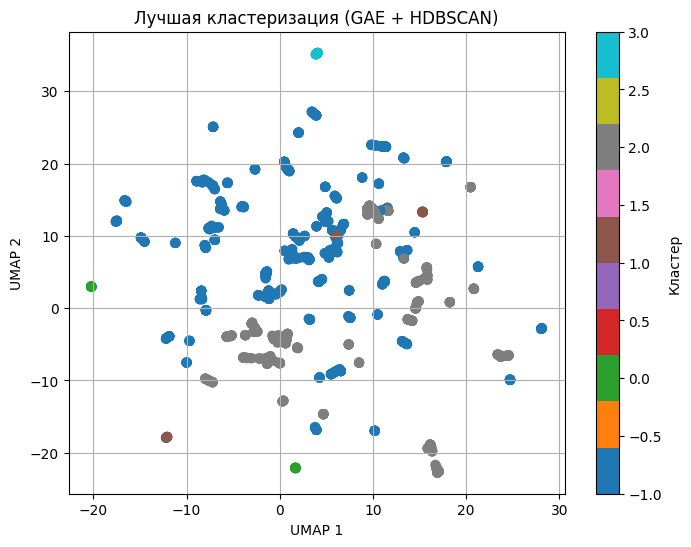

In [ ]:


# --- Подготовка данных ---
df_transformed_filled = df_transformed.copy()
ids = df_transformed_filled['card_id'].values
features_scaled = df_transformed_filled.drop(columns='card_id').values.astype(np.float32)


# Функция построения kNN графа
def build_knn_graph(features_np, k=10):
    index = faiss.IndexFlatL2(features_np.shape[1])
    index.add(features_np)
    distances, neighbors = index.search(features_np, k + 1)
    edge_index = []
    for i in range(features_np.shape[0]):
        for j in neighbors[i][1:]:
            edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

edge_index = build_knn_graph(features_scaled, k=10)

x = torch.tensor(features_scaled, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# GAT энкодер для GAE
class GATEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=2, dropout=dropout)
        self.conv2 = GATConv(2 * out_channels * 2, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

best_score = float('inf')
best_params = {}
best_labels = None
best_embedding = None

for embedding_dim in [32, 64, 128]:
    for dropout_rate in [0.2, 0.3, 0.4]:
        for min_cluster_size in [10,15,25, 30,35,45,55]:
            print(f"\n➡️ Testing: dim={embedding_dim}, dropout={dropout_rate}, min_cluster_size={min_cluster_size}")

            encoder = GATEncoder(in_channels=x.shape[1], out_channels=embedding_dim, dropout=dropout_rate)
            model = GAE(encoder).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

            model.train()
            for epoch in range(100):
                optimizer.zero_grad()
                z = model.encode(data.x, data.edge_index)
                loss = model.recon_loss(z, data.edge_index)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                z = model.encode(data.x, data.edge_index)
            z_np = z.cpu().numpy()

            clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
            labels = clusterer.fit_predict(z_np)

            valid = labels != -1
            labels_valid = labels[valid]
            z_valid = z_np[valid]

            if len(set(labels_valid)) >= 3:
                silhouette = silhouette_score(z_valid, labels_valid)
                ch_score = calinski_harabasz_score(z_valid, labels_valid)
                db_score = davies_bouldin_score(z_valid, labels_valid)

                print(f"✅ Silhouette Score: {silhouette:.4f}")
                print(f"📈 Calinski-Harabasz Index: {ch_score:.2f}")
                print(f"📉 Davies-Bouldin Index: {db_score:.4f}")

                if db_score < best_score:
                    best_score = db_score
                    best_params = {
                        "embedding_dim": embedding_dim,
                        "dropout": dropout_rate,
                        "min_cluster_size": min_cluster_size,
                        "Calinski-Harabasz": ch_score,
                        "Silhouette": silhouette,
                        "Davies-Bouldin": db_score
                    }
                    best_labels = labels
                    best_embedding = z_np
            else:
                print("❌ Недостаточно кластеров для оценки (меньше 3)")

print("\n🏆 ЛУЧШИЕ ПАРАМЕТРЫ (по минимальному Davies-Bouldin Index):")
print(best_params)

# --- Сохраняем кластеризацию ---
cluster_df = pd.DataFrame({
    "card_id": ids,
    "cluster": best_labels
})

# --- Визуализация с UMAP ---

z_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(best_embedding)
plt.figure(figsize=(8, 6))
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=best_labels, cmap='tab10', s=40)
plt.title("Лучшая кластеризация (GAE + HDBSCAN)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Кластер')
plt.grid(True)
plt.show()



# Финальное описание кластеров клиентов по HDBSCAN.
Кластер -1 (Шум: Атипичное поведение, равномерные расходы. Возможны технические записи или сбои.)

Поведение и расходы: Атипичное поведение с равномерными расходами, вероятно, обусловлено техническими записями или сбоями в данных.
Частота транзакций: Транзакции совершаются со средней частотой (медиана около 4200 секунд или 1 час 10 минут между транзакциями).
Предпочитаемые POS-режимы: Наблюдается равномерное распределение долей трат между Contactless, QR_Code и ECOM (около 0.2-0.28).
Предпочитаемые кошельки: Bank's QR доминирует (около 0.4), в то время как Apple Pay, Google Pay и Samsung Pay имеют схожие более низкие доли (около 0.2).
Категории трат: Основная доля трат приходится на "другие услуги" (services_other, около 0.45) и "повседневные нужды" (daily_essentials, около 0.23).
Иностранные/Конвертированные транзакции: Доля таких транзакций крайне мала (около 0.0088%), что может быть связано с аномалиями или случайными операциями.
Сезонность: Относительно равномерные траты по месяцам, с небольшим ростом к концу года.
Кластер 0 (Клиенты с высокими расходами. Пик трат 8:00–15:00. Вероятно, премиум/корпоративные.)

Поведение и расходы: Характеризуются высокими расходами, с пиком активности в рабочее время (8:00–15:00), что указывает на премиум или корпоративный сегмент.
Частота транзакций: Совершают транзакции наиболее часто среди всех кластеров (медиана около 3200 секунд или 53 минуты 20 секунд между транзакциями).
Предпочитаемые POS-режимы: QR_Code является доминирующим режимом (около 0.35), что подтверждает корреляцию с использованием Bank's QR. Contactless также демонстрирует высокую долю (около 0.29).
Предпочитаемые кошельки: Bank's QR достигает своего пика (почти 0.5), что свидетельствует о его активном использовании для крупных или корпоративных платежей. Другие кошельки имеют долю около 0.17.
Категории трат: Подавляющая доля трат приходится на "другие услуги" (services_other, более 0.55), что может включать дорогие или специализированные сервисы.
Иностранные/Конвертированные транзакции: Доля крайне мала (около 0.0088%), несмотря на высокие расходы, что может указывать на преимущественно локальный характер операций.
Сезонность: Относительно равномерное распределение трат по месяцам, с небольшими увеличениями в летний период и к концу года.
Кластер 1 (Активные пользователи с умеренными расходами. Расходы распределены, пик 8:00–14:00. Розничные клиенты.)

Поведение и расходы: Активные розничные клиенты с умеренными расходами, чья активность распределена в течение дня, с пиком в первой половине дня (8:00–14:00).
Частота транзакций: Совершают транзакции со средней частотой (медиана около 5500 секунд или 1 час 31 минута 40 секунд между транзакциями).
Предпочитаемые POS-режимы: Contactless является доминирующим (около 0.31), что соответствует удобству для повседневных покупок. QR_Code также имеет значительную долю (около 0.26).
Предпочитаемые кошельки: Bank's QR сохраняет высокую долю (около 0.42), а другие кошельки стабильны на уровне 0.18-0.19.
Категории трат: Основные траты приходятся на "другие услуги" (services_other, около 0.47), а также "повседневные нужды" (daily_essentials, около 0.2) и "одежду/розницу" (retail_apparel, около 0.15).
Иностранные/Конвертированные транзакции: Наибольшая доля среди всех кластеров (около 0.0108%), что может быть связано с их активностью и разнообразием покупок, включая онлайн.
Сезонность: Относительно равномерное распределение трат в течение года, с небольшим ростом в летние месяцы и пиком в декабре.
Кластер 2 (Клиенты с низкими расходами. Основная активность 8:00–13:00. Возможно, молодые или с ограниченным использованием карты.)

Поведение и расходы: Характеризуются низкими расходами и активностью, сосредоточенной в утренние часы (8:00–13:00). Вероятно, это молодые пользователи или лица с ограниченным использованием карт.
Частота транзакций: Совершают транзакции крайне редко (медиана около 12500 секунд или 3 часа 28 минут 20 секунд между транзакциями), что является самым высоким показателем среди всех кластеров.
Предпочитаемые POS-режимы: Contactless является наиболее популярным режимом (около 0.33), вероятно, для быстрых и мелких платежей. Доля QR_Code заметно ниже (около 0.18).
Предпочитаемые кошельки: Bank's QR имеет долю около 0.4, но другие кошельки показывают наименьшие доли (около 0.15-0.16) по сравнению с другими кластерами.
Категории трат: Основная доля приходится на "другие услуги" (services_other, около 0.55) и "повседневные нужды" (daily_essentials, около 0.24).
Иностранные/Конвертированные транзакции: Доля близка к нулю, что соответствует их низким расходам и ограниченному использованию карт.
Сезонность: Низкие доли трат на протяжении большей части года, с небольшим ростом в октябре и заметным пиком в декабре.
Кластер 3 (Средний уровень трат, пик 8:00–18:00. Поведение указывает на рабочий график (офисные сотрудники, стабильные покупатели).)

Поведение и расходы: Клиенты со средним уровнем трат, чье поведение указывает на рабочий график (пик активности 8:00–18:00), характерный для офисных сотрудников или стабильных покупателей.
Частота транзакций: Совершают транзакции со средней частотой (медиана около 4900 секунд или 1 час 21 минута 40 секунд между транзакциями).
Предпочитаемые POS-режимы: Наблюдается сбалансированное использование Contactless (около 0.29) и QR_Code (около 0.28).
Предпочитаемые кошельки: Bank's QR сохраняет высокую долю (около 0.43), другие кошельки около 0.17-0.18.
Категории трат: Значительные доли приходятся как на "другие услуги" (services_other, около 0.4), так и на "повседневные нужды" (daily_essentials, около 0.37), что является самым высоким показателем для этой категории.
Иностранные/Конвертированные транзакции: Доля близка к нулю, что указывает на преимущественно локальные транзакции, связанные с их рабочим и повседневным графиком.
Сезонность: Ярко выраженный пик трат в конце года (ноябрь-декабрь, особенно в декабре - более 0.45), что, вероятно, связано с праздничными покупками или бонусами.
Общий вывод:
Анализ кластеров демонстрирует различные поведенческие паттерны: от атипичных "шумовых" транзакций до высокоактивных премиум-клиентов и стабильных офисных работников. Bank's QR является доминирующим методом оплаты для всех кластеров, а "другие услуги" – ключевой категорией трат. Различия в частоте транзакций, предпочтениях POS-режимов и сезонности трат позволяют более точно сегментировать клиентскую базу. Доля иностранных и конвертированных транзакций остается крайне низкой для большинства кластеров.
## Вся графики и статистика, а также описание для других моделей внизу.

In [ ]:
print(cluster_df['cluster'].value_counts())
H_df = final_df.merge(cluster_df, on='card_id', how='left')


cluster
-1    1232
 2     643
 3      50
 1      39
 0      36
Name: count, dtype: int64


['card_id',
 'spending_hour_0',
 'spending_hour_1',
 'spending_hour_2',
 'spending_hour_3',
 'spending_hour_4',
 'spending_hour_5',
 'spending_hour_6',
 'spending_hour_7',
 'spending_hour_8',
 'spending_hour_9',
 'spending_hour_10',
 'spending_hour_11',
 'spending_hour_12',
 'spending_hour_13',
 'spending_hour_14',
 'spending_hour_15',
 'spending_hour_16',
 'spending_hour_17',
 'spending_hour_18',
 'spending_hour_19',
 'spending_hour_20',
 'spending_hour_21',
 'spending_hour_22',
 'spending_hour_23',
 'spending_day_name_Friday',
 'spending_day_name_Monday',
 'spending_day_name_Saturday',
 'spending_day_name_Sunday',
 'spending_day_name_Thursday',
 'spending_day_name_Tuesday',
 'spending_day_name_Wednesday',
 'spending_month_name_April',
 'spending_month_name_August',
 'spending_month_name_December',
 'spending_month_name_February',
 'spending_month_name_January',
 'spending_month_name_July',
 'spending_month_name_June',
 'spending_month_name_March',
 'spending_month_name_May',
 'spendi

# Создаем графики и дескриптив статистику по кластерам.
Кластер -1 (Шум):
Атипичное поведение, равномерное распределение трат без выраженных пиков. Возможны технические ошибки, тестовые транзакции или некорректные данные.
Кластер 0 (Премиум/корпоративные клиенты):
Высокий уровень расходов с четким пиком активности между 8:00 и 15:00. Вероятно, это состоятельные клиенты или компании, совершающие крупные платежи в первой половине дня.

Кластер 1 (Активные розничные клиенты):
Умеренные траты с равномерным распределением и небольшим пиком с 8:00 до 14:00. Типичные пользователи карт для повседневных покупок.

Кластер 2 (Экономные/молодые клиенты):
Низкие расходы с основной активностью в утренние часы (8:00–13:00). Возможно, студенты или пользователи с ограниченным бюджетом.

Кластер 3 (Офисные сотрудники/стабильные покупатели):
Средний уровень трат с широким диапазоном активности (8:00–18:00). Характерно для людей с фиксированным рабочим графиком и регулярными покупками.


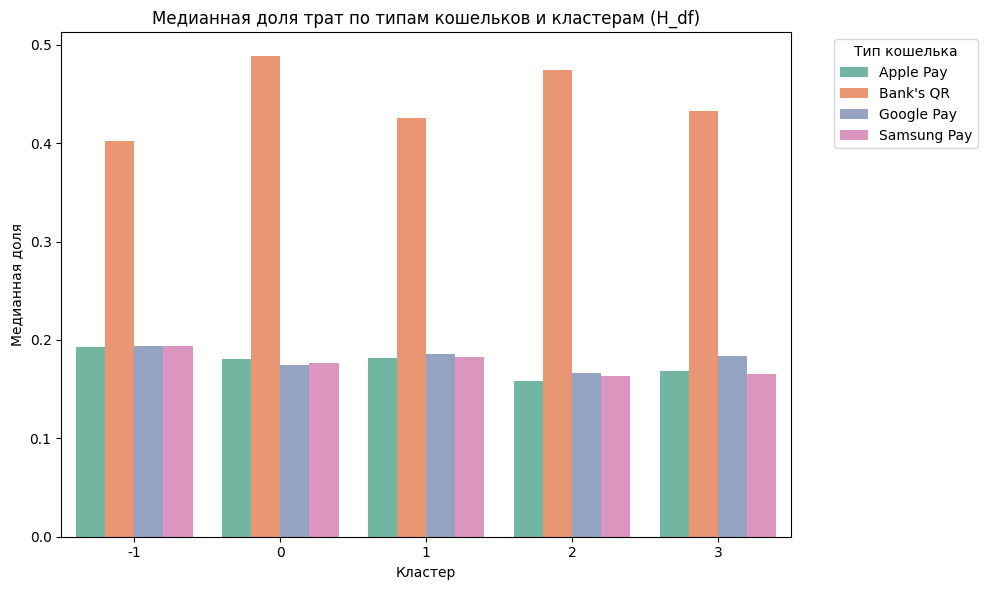

In [ ]:
wallet_cols = [col for col in H_df.columns if col.startswith('share_wallet_type_spending_wallet_type_')]

# Шаг 2: Группировка по кластеру и вычисление медиан
cluster_wallet_share = H_df.groupby('cluster')[wallet_cols].median()

# Шаг 3: Переименование колонок — убираем префикс
prefix = 'share_wallet_type_spending_wallet_type_'
cluster_wallet_share.columns = [col.replace(prefix, '') for col in cluster_wallet_share.columns]

# Шаг 4: Преобразование в long формат
cluster_wallet_share_long = cluster_wallet_share.reset_index().melt(
    id_vars='cluster',
    var_name='wallet_type',
    value_name='median_share'
)

# Шаг 5: Построение barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_wallet_share_long,
    x='cluster',
    y='median_share',
    hue='wallet_type',
    palette='Set2'
)

plt.title('Медианная доля трат по типам кошельков и кластерам (H_df)')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='Тип кошелька', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Кластер -1 (Шум: Атипичное поведение, равномерные расходы. Возможны технические записи или сбои.)
Этот кластер характеризуется атипичным и равномерным поведением расходов, что может быть связано с техническими записями или сбоями. Медианная доля трат равномерно распределена между различными POS-режимами, при этом Contactless, QR_Code и ECOM имеют схожие высокие доли (около 0.2-0.28). Среди кошельков Bank's QR показывает значительную долю (около 0.4), тогда как Apple Pay, Google Pay и Samsung Pay находятся на уровне около 0.2. Даже в этом "шумовом" сегменте прослеживается доминирование Bank's QR, что может быть связано с его широким спектром применения.

Кластер 0 (Клиенты с высокими расходами. Пик трат 8:00–15:00. Вероятно, премиум/корпоративные.)
Это клиенты с высокими расходами, активность которых пиковая в период с 8:00 до 15:00, что указывает на премиум или корпоративный сегмент. QR_Code является доминирующим POS-режимом (около 0.35), что является самым высоким показателем среди всех кластеров для этого режима. Contactless также демонстрирует высокую долю (около 0.29). Среди кошельков Bank's QR достигает своего пика (почти 0.5), что подтверждает его использование для крупных или корпоративных платежей.

Кластер 1 (Активные пользователи с умеренными расходами. Расходы распределены, пик 8:00–14:00. Розничные клиенты.)
Это активные пользователи с умеренными расходами, с распределенной активностью и пиком трат с 8:00 до 14:00, типичные для розничных клиентов. Для них характерно доминирование Contactless (около 0.31) и значительная доля QR_Code (около 0.26). Медианная доля Bank's QR составляет около 0.42, в то время как другие кошельки держатся на уровне 0.18-0.19. Это указывает на предпочтение удобных и быстрых способов оплаты для повседневных покупок.

Кластер 2 (Клиенты с низкими расходами. Основная активность 8:00–13:00. Возможно, молодые или с ограниченным использованием карты.)
Этот кластер включает клиентов с низкими расходами, основной активностью с 8:00 до 13:00. Вероятно, это молодые пользователи или те, кто ограниченно пользуется картами. Contactless является наиболее популярным POS-режимом (около 0.33), достигая своего пика в этом кластере, в то время как QR_Code имеет сниженную долю (около 0.18). Доля Bank's QR составляет около 0.4, а другие кошельки имеют наименьшие значения (около 0.15-0.16) по сравнению с другими кластерами. Это говорит о предпочтении быстрых и удобных способов оплаты для небольших сумм.

Кластер 3 (Средний уровень трат, пик 8:00–18:00. Поведение указывает на рабочий график (офисные сотрудники, стабильные покупатели).)
Клиенты этого кластера демонстрируют средний уровень трат, с пиком активности с 8:00 до 18:00, что соответствует рабочему графику офисных сотрудников или стабильных покупателей. Contactless (около 0.29) и QR_Code (около 0.28) имеют схожие высокие доли. Bank's QR также показывает высокую медианную долю (около 0.43), а другие кошельки держатся на уровне 0.17-0.18. Такое распределение указывает на разнообразное использование платежных методов, соответствующее различным повседневным и рабочим сценариям.

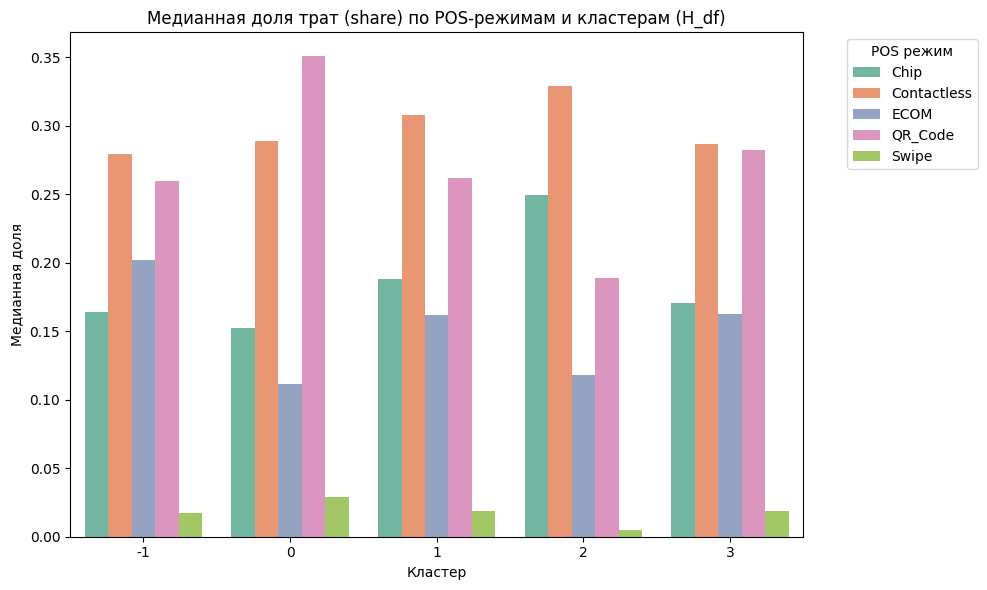

In [ ]:
# Шаг 1: Выбрать колонки, начинающиеся с 'share_pos_entry_mode_spending_pos_entry_mode_'
pos_share_cols = [col for col in H_df.columns if col.startswith('share_pos_entry_mode_spending_pos_entry_mode_')]

# Шаг 2: Группировка по кластеру и вычисление медиан
cluster_pos_share = H_df.groupby('cluster')[pos_share_cols].median()

# Шаг 3: Переименование колонок — убираем префикс
prefix = 'share_pos_entry_mode_spending_pos_entry_mode_'
cluster_pos_share.columns = [col.replace(prefix, '') for col in cluster_pos_share.columns]

# Шаг 4: Преобразование в long формат
cluster_pos_share_long = cluster_pos_share.reset_index().melt(
    id_vars='cluster',
    var_name='pos_entry_mode',
    value_name='median_share'
)

# Шаг 5: Построение barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_pos_share_long,
    x='cluster',
    y='median_share',
    hue='pos_entry_mode',
    palette='Set2'
)

plt.title('Медианная доля трат (share) по POS-режимам и кластерам (H_df)')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='POS режим', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
cluster_pos_share

,Chip,Contactless,ECOM,QR_Code,Swipe
cluster,,,,,
-1,0.164927,0.242899,0.186059,0.259574,0.006624
0,0.176745,0.291452,0.162416,0.246446,0.014412
1,0.08016,0.08806,0.790311,0.04917,0.0
2,0.42041,0.394407,0.0,0.163295,0.0


In [ ]:
H_df.groupby('cluster').median()

,card_id,spending_hour_0,spending_hour_1,spending_hour_2,spending_hour_3,spending_hour_4,spending_hour_5,spending_hour_6,spending_hour_7,spending_hour_8,...,"share_mcc_category_spending_mcc_category_Hobby, Books, Sporting Goods",share_mcc_category_spending_mcc_category_Home Furnishings & Supplies,share_mcc_category_spending_mcc_category_Pharmacies & Health,share_mcc_category_spending_mcc_category_Services (Other),share_mcc_category_spending_mcc_category_Travel & Transportation,share_mcc_category_spending_mcc_category_Unknown,share_mcc_category_spending_mcc_category_Utilities & Bill Payments,avg_time_between_txn,share_foreign_txn,share_converted_txn
cluster,,,,,,,,,,,,,,,,,,,,,
-1,11017.5,1846478.21,874839.805,849001.415,849668.435,861496.895,1791509.37,3610527.94,7389525.1,10161968.36,...,0.002828,0.012584,0.003494,0.094008,0.02857,0.263677,0.070657,4243.386596,0.000000,0.000000
0,10790.5,5436045.015,2264886.905,2683263.29,2379341.75,2396065.335,5205820.895,10891833.325,23533481.355,29275349.04,...,0.002326,0.01027,0.002447,0.407739,0.027185,0.14041,0.052851,3125.072584,0.000088,0.000088
1,10997.0,1451871.85,650346.97,750202.25,625938.4,678727.5,1442257.03,2729618.74,5796667.46,8095526.37,...,0.004301,0.016683,0.00575,0.117922,0.033882,0.359843,0.090158,5510.805621,0.000107,0.000107
2,10976.0,119020.34,54047.23,52599.51,46876.73,45209.12,122348.95,257431.93,536792.7,1188737.22,...,0.001296,0.005772,0.002132,0.046746,0.012628,0.443442,0.089519,12564.949191,0.000000,0.000000
3,10904.0,318218.215,157002.825,177591.53,154269.225,140375.885,325067.78,795738.455,1814027.445,2314499.025,...,0.001671,0.008713,0.0035,0.12029,0.016352,0.228763,0.226592,4880.781730,0.000000,0.000000


Кластер -1 (Шум):
Атипичные, равномерные расходы.
Медианное время между транзакциями: Среднее (около 4200 секунд, или 1 час 10 минут).
POS-режимы: Схожие доли Contactless, QR_Code, ECOM (0.2-0.28).
Кошельки: Bank's QR доминирует (0.4), другие ~0.2.

Кластер 0 (Высокие расходы / Премиум):
Пик трат 8:00–15:00.
Медианное время между транзакциями: Низкое (около 3200 секунд, или 53 минуты 20 секунд). Это указывает на частые, возможно, крупные транзакции.
POS-режимы: QR_Code доминирует (0.35), Contactless высок (0.29).
Кошельки: Bank's QR пик (~0.5), другие ~0.17.

Кластер 1 (Активные / Розничные):
Умеренные расходы, пик трат 8:00–14:00.
Медианное время между транзакциями: Среднее (около 5500 секунд, или 1 час 31 минута 40 секунд).
POS-режимы: Contactless доминирует (0.31), QR_Code высок (0.26).
Кошельки: Bank's QR (0.42), другие ~0.18.

Кластер 2 (Низкие расходы / Молодые):
Активность 8:00–13:00.
Медианное время между транзакциями: Очень высокое (около 12500 секунд, или 3 часа 28 минут 20 секунд). Это означает, что транзакции совершаются крайне редко.
POS-режимы: Contactless наиболее популярен (0.33), QR_Code снижен (0.18).
Кошельки: Bank's QR (0.4), другие наименьшие (0.15-0.16).

Кластер 3 (Средние траты / Офисные сотрудники):
Пик трат 8:00–18:00 (рабочий график).
Медианное время между транзакциями: Среднее (около 4900 секунд, или 1 час 21 минута 40 секунд).
POS-режимы: Сбалансированное использование Contactless (0.29) и QR_Code (0.28).
Кошельки: Bank's QR высок (0.43), другие ~0.17.


<ipython-input-82-179d163a2461>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-82-179d163a2461>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


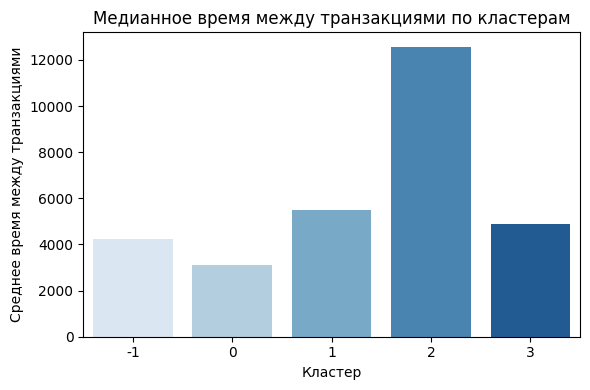

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=H_df,
    x='cluster',
    y='avg_time_between_txn',
    estimator='median',
    ci=None,
    palette='Blues'
)
plt.title('Медианное время между транзакциями по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Среднее время между транзакциями')
plt.tight_layout()
plt.show()


Кластер -1 (Шум):

Атипичные, равномерные расходы.
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%). Это указывает на крайне редкие иностранные транзакции, которые могут быть частью "шума" или аномальных записей.
Медианное время между транзакциями: Среднее (около 4200 секунд, или 1 час 10 минут).
POS-режимы: Схожие доли Contactless, QR_Code, ECOM (0.2-0.28).
Кошельки: Bank's QR доминирует (0.4), другие ~0.2.
Кластер 0 (Высокие расходы / Премиум):

Пик трат 8:00–15:00.
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%). Это говорит о том, что даже у клиентов с высокими расходами доля иностранных транзакций крайне мала.
Медианное время между транзакциями: Низкое (около 3200 секунд, или 53 минуты 20 секунд). Это указывает на частые, возможно, крупные транзакции.
POS-режимы: QR_Code доминирует (0.35), Contactless высок (0.29).
Кошельки: Bank's QR пик (~0.5), другие ~0.17.
Кластер 1 (Активные / Розничные):

Умеренные расходы, пик трат 8:00–14:00.
Медианная доля иностранных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров, для которых есть данные. Хотя доля все еще очень мала, это может указывать на то, что активные розничные клиенты чаще совершают международные покупки, возможно, онлайн.
Медианное время между транзакциями: Среднее (около 5500 секунд, или 1 час 31 минута 40 секунд).
POS-режимы: Contactless доминирует (0.31), QR_Code высок (0.26).
Кошельки: Bank's QR (0.42), другие ~0.18.
Кластер 2 (Низкие расходы / Молодые):

Активность 8:00–13:00.
Медианная доля иностранных транзакций: Близка к нулю. Это ожидаемо, учитывая их низкие расходы и возможное ограниченное использование карты.
Медианное время между транзакциями: Очень высокое (около 12500 секунд, или 3 часа 28 минут 20 секунд). Это означает, что транзакции совершаются крайне редко.
POS-режимы: Contactless наиболее популярен (0.33), QR_Code снижен (0.18).
Кошельки: Bank's QR (0.4), другие наименьшие (0.15-0.16).
Кластер 3 (Средние траты / Офисные сотрудники):

Пик трат 8:00–18:00 (рабочий график).
Медианная доля иностранных транзакций: Близка к нулю. Возможно, их транзакции преимущественно локальны и связаны с работой или повседневными покупками.
Медианное время между транзакциями: Среднее (около 4900 секунд, или 1 час 21 минута 40 секунд).
POS-режимы: Сбалансированное использование Contactless (0.29) и QR_Code (0.28).
Кошельки: Bank's QR высок (0.43), другие ~0.17.

<ipython-input-83-9eced8adb2e4>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-83-9eced8adb2e4>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


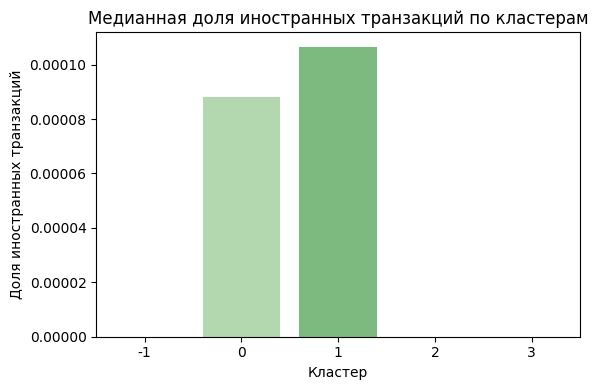

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=H_df,
    x='cluster',
    y='share_foreign_txn',
    estimator='median',
    ci=None,
    palette='Greens'
)
plt.title('Медианная доля иностранных транзакций по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Доля иностранных транзакций')
plt.tight_layout()
plt.show()


Кластер -1 (Шум):

Атипичные, равномерные расходы.
Медианная доля конвертированных транзакций: Около 0.000088 (0.0088%). Это крайне низкая доля, что соответствует "шумовому" характеру кластера.
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%).
Медианное время между транзакциями: Среднее (около 4200 секунд, или 1 час 10 минут).
POS-режимы: Схожие доли Contactless, QR_Code, ECOM (0.2-0.28).
Кошельки: Bank's QR доминирует (0.4), другие ~0.2.
Кластер 0 (Высокие расходы / Премиум):

Пик трат 8:00–15:00.
Медианная доля конвертированных транзакций: Около 0.000088 (0.0088%). Несмотря на высокие расходы, доля конвертированных транзакций крайне мала.
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%).
Медианное время между транзакциями: Низкое (около 3200 секунд, или 53 минуты 20 секунд). Это указывает на частые, возможно, крупные транзакции.
POS-режимы: QR_Code доминирует (0.35), Contactless высок (0.29).
Кошельки: Bank's QR пик (~0.5), другие ~0.17.
Кластер 1 (Активные / Розничные):

Умеренные расходы, пик трат 8:00–14:00.
Медианная доля конвертированных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров, для которых есть данные. Это может быть связано с тем, что активные розничные клиенты чаще пользуются различными сервисами, которые могут включать конвертацию валюты или другие типы конвертированных операций.
Медианная доля иностранных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров.
Медианное время между транзакциями: Среднее (около 5500 секунд, или 1 час 31 минута 40 секунд).
POS-режимы: Contactless доминирует (0.31), QR_Code высок (0.26).
Кошельки: Bank's QR (0.42), другие ~0.18.
Кластер 2 (Низкие расходы / Молодые):

Активность 8:00–13:00.
Медианная доля конвертированных транзакций: Близка к нулю. Это соответствует их низким расходам и ограниченному использованию карт.
Медианная доля иностранных транзакций: Близка к нулю.
Медианное время между транзакциями: Очень высокое (около 12500 секунд, или 3 часа 28 минут 20 секунд). Это означает, что транзакции совершаются крайне редко.
POS-режимы: Contactless наиболее популярен (0.33), QR_Code снижен (0.18).
Кошельки: Bank's QR (0.4), другие наименьшие (0.15-0.16).
Кластер 3 (Средние траты / Офисные сотрудники):

Пик трат 8:00–18:00 (рабочий график).
Медианная доля конвертированных транзакций: Близка к нулю. Вероятно, их транзакции преимущественно локальны и не требуют конвертации.
Медианная доля иностранных транзакций: Близка к нулю.
Медианное время между транзакциями: Среднее (около 4900 секунд, или 1 час 21 минута 40 секунд).
POS-режимы: Сбалансированное использование Contactless (0.29) и QR_Code (0.28).
Кошельки: Bank's QR высок (0.43), другие ~0.17.

<ipython-input-84-5bc0bbdce309>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-84-5bc0bbdce309>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


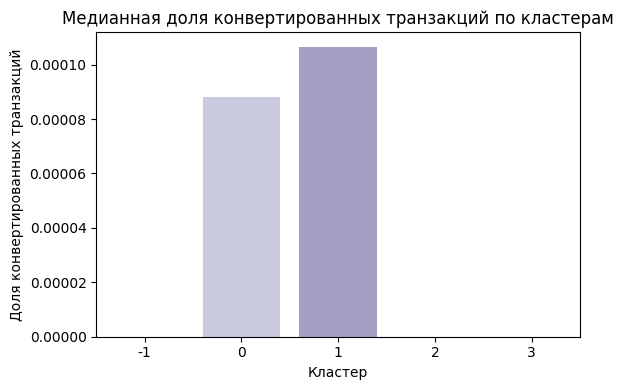

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=H_df,
    x='cluster',
    y='share_converted_txn',
    estimator='median',
    ci=None,
    palette='Purples'
)
plt.title('Медианная доля конвертированных транзакций по кластерам')
plt.xlabel('Кластер')
plt.ylabel('Доля конвертированных транзакций')
plt.tight_layout()
plt.show()


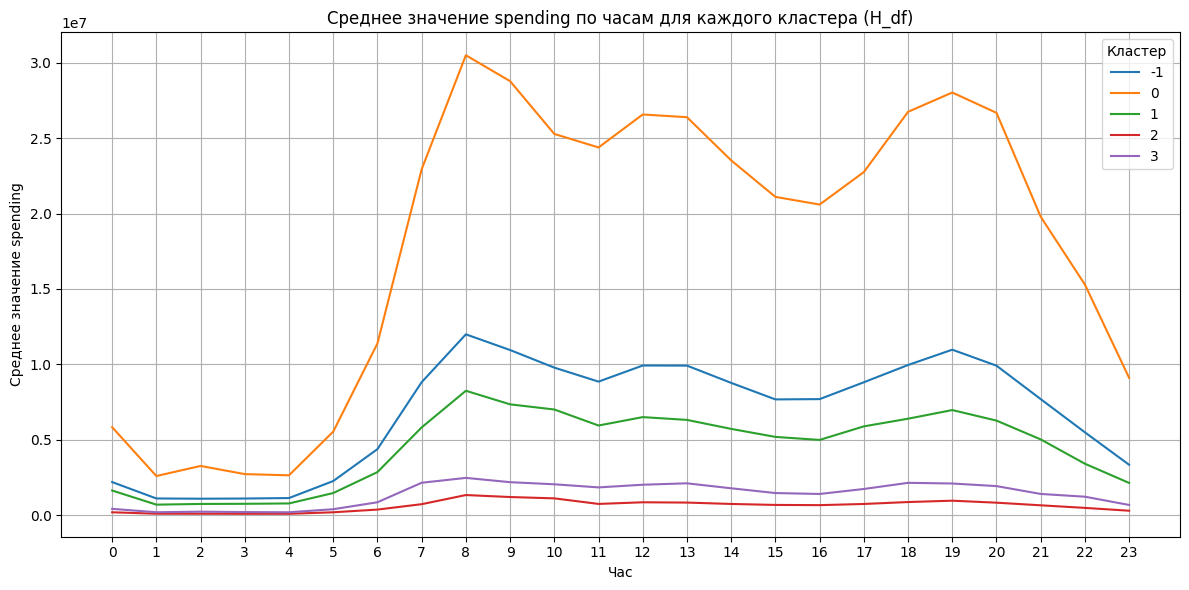

In [ ]:
# Выбираем колонки с нужным префиксом и колонку 'cluster'
cols_H = [col for col in H_df.columns if col.startswith('spending_hour_') or col == 'cluster']

# Создаем датафрейм с этими колонками
selected_H_df = H_df[cols_H].copy()

# Преобразуем из wide в long, используя 'cluster' как id_var
df_long_H = selected_H_df.melt(id_vars='cluster', var_name='hour', value_name='value')
df_long_H['value'] = pd.to_numeric(df_long_H['value'], errors='coerce')

# Очистка названий часов от префикса
prefix = 'spending_hour_'
df_long_H['hour'] = df_long_H['hour'].str.replace(prefix, '', regex=False).str.strip('_')

# Приводим колонку 'hour' к числовому типу для корректного отображения по оси X
df_long_H['hour'] = pd.to_numeric(df_long_H['hour'], errors='coerce')

grouped_H = df_long_H.groupby(['cluster', 'hour'])['value'].mean().reset_index()

# Построение line-графика
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_H, x='hour', y='value', hue='cluster', palette='tab10')

plt.title('Среднее значение spending по часам для каждого кластера (H_df)')
plt.xlabel('Час')
plt.ylabel('Среднее значение spending')
plt.xticks(range(0, 24))  # если часы идут от 0 до 23
plt.grid(True)
plt.legend(title='Кластер')
plt.tight_layout()
plt.show()


## 💳 1. Повседневные покупки (Daily Essentials)
- Grocery & Food Markets  
- Pharmacies & Health  
- Utilities & Bill Payments  

## 🛍 2. Розничная торговля и мода (Retail & Apparel)
- Clothing & Apparel  
- General Retail & Department  
- Home Furnishings & Supplies  

## 🍽 3. Еда и рестораны (Dining)
- Dining & Restaurants  

## ⛽ 4. Транспорт и топливо (Transport & Fuel)
- Fuel & Service Stations  
- Travel & Transportation  

## 💻 5. Электроника и хобби (Electronics & Leisure)
- Electronics & Software  
- Hobby, Books, Sporting Goods  

## 🛠 6. Услуги и прочее (Services & Other)
- Services (Other)  
- Unknown  

Кластер -1 (Шум):

Атипичные, равномерные расходы.
Медианная доля трат по категориям:
"services_other" доминирует (около 0.45).
"daily_essentials" также значимы (около 0.23).
Остальные категории ("retail_apparel", "dining", "transport_fuel", "electronics_leisure") имеют низкие доли (менее 0.1).
Медианная доля конвертированных транзакций: Около 0.000088 (0.0088%).
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%).
Медианное время между транзакциями: Среднее (около 4200 секунд, или 1 час 10 минут).
POS-режимы: Схожие доли Contactless, QR_Code, ECOM (0.2-0.28).
Кошельки: Bank's QR доминирует (0.4), другие ~0.2.
Кластер 0 (Высокие расходы / Премиум):

Пик трат 8:00–15:00.
Медианная доля трат по категориям:
"services_other" значительно доминирует (более 0.55), достигая своего пика.
"daily_essentials" и "retail_apparel" также заметны (около 0.15 и 0.12 соответственно).
"dining", "transport_fuel", "electronics_leisure" имеют низкие доли.
Медианная доля конвертированных транзакций: Около 0.000088 (0.0088%).
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%).
Медианное время между транзакциями: Низкое (около 3200 секунд, или 53 минуты 20 секунд). Это указывает на частые, возможно, крупные транзакции.
POS-режимы: QR_Code доминирует (0.35), Contactless высок (0.29).
Кошельки: Bank's QR пик (~0.5), другие ~0.17.
Вывод: Высокие расходы этого кластера во многом обусловлены тратами на "другие услуги", что может включать дорогие сервисы, характерные для премиум-сегмента.
Кластер 1 (Активные / Розничные):

Умеренные расходы, пик трат 8:00–14:00.
Медианная доля трат по категориям:
"services_other" доминирует (около 0.47).
"daily_essentials" и "retail_apparel" также значимы (около 0.2 и 0.15 соответственно).
"dining", "transport_fuel", "electronics_leisure" имеют низкие доли.
Медианная доля конвертированных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров.
Медианная доля иностранных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров.
Медианное время между транзакциями: Среднее (около 5500 секунд, или 1 час 31 минута 40 секунд).
POS-режимы: Contactless доминирует (0.31), QR_Code высок (0.26).
Кошельки: Bank's QR (0.42), другие ~0.18.
Вывод: Активные розничные клиенты, помимо повседневных покупок, активно пользуются различными услугами.
Кластер 2 (Низкие расходы / Молодые):

Активность 8:00–13:00.
Медианная доля трат по категориям:
"services_other" доминирует (около 0.55).
"daily_essentials" также значимы (около 0.24).
"retail_apparel" и "dining" имеют низкие доли, "transport_fuel" и "electronics_leisure" минимальны.
Медианная доля конвертированных транзакций: Близка к нулю.
Медианная доля иностранных транзакций: Близка к нулю.
Медианное время между транзакциями: Очень высокое (около 12500 секунд, или 3 часа 28 минут 20 секунд). Это означает, что транзакции совершаются крайне редко.
POS-режимы: Contactless наиболее популярен (0.33), QR_Code снижен (0.18).
Кошельки: Bank's QR (0.4), другие наименьшие (0.15-0.16).
Вывод: Низкие расходы и редкие транзакции, вероятно, связаны с ограниченным использованием карт, где "другие услуги" могут включать базовые цифровые сервисы или подписки.
Кластер 3 (Средние траты / Офисные сотрудники):

Пик трат 8:00–18:00 (рабочий график).
Медианная доля трат по категориям:
"services_other" доминирует (около 0.4).
"daily_essentials" также высок (около 0.37), это самый высокий показатель среди всех кластеров для этой категории.
"retail_apparel" и "dining" имеют средние доли. "transport_fuel" и "electronics_leisure" минимальны.
Медианная доля конвертированных транзакций: Близка к нулю.
Медианная доля иностранных транзакций: Близка к нулю.
Медианное время между транзакциями: Среднее (около 4900 секунд, или 1 час 21 минута 40 секунд).
POS-режимы: Сбалансированное использование Contactless (0.29) и QR_Code (0.28).
Кошельки: Bank's QR высок (0.43), другие ~0.17.
Вывод: Кластер стабильных покупателей и офисных сотрудников ожидаемо демонстрирует высокие траты на "повседневные нужды" и "другие услуги", что соответствует их регулярным потребностям.

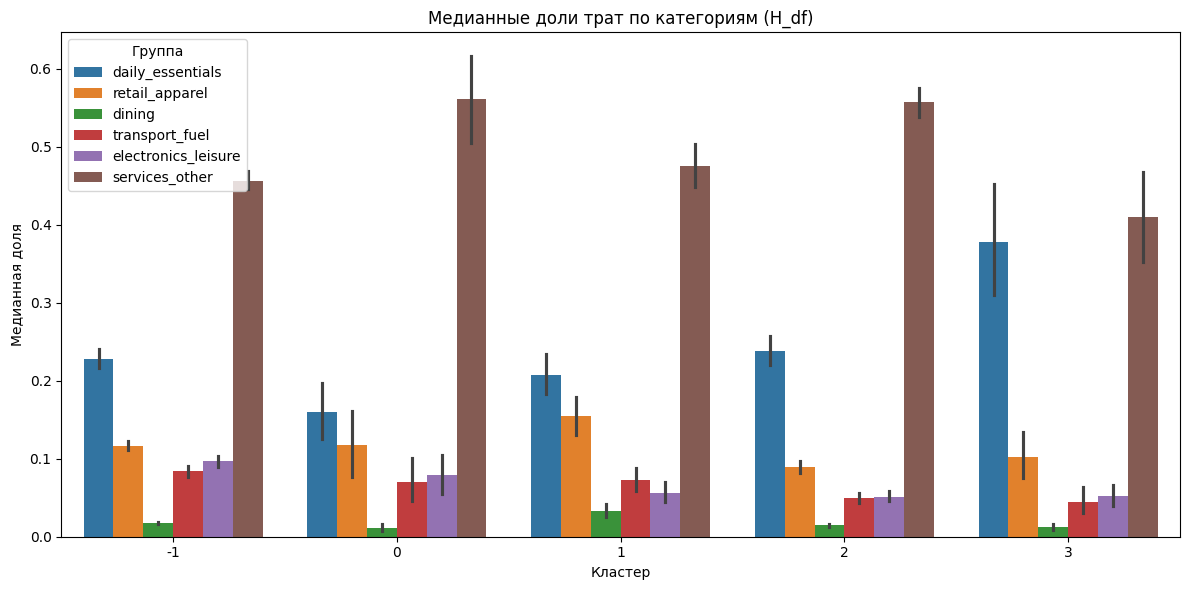

In [ ]:
grouped_mcc_columns = {
    'daily_essentials': [
        'share_mcc_category_spending_mcc_category_Grocery & Food Markets',
        'share_mcc_category_spending_mcc_category_Pharmacies & Health',
        'share_mcc_category_spending_mcc_category_Utilities & Bill Payments'
    ],
    'retail_apparel': [
        'share_mcc_category_spending_mcc_category_Clothing & Apparel',
        'share_mcc_category_spending_mcc_category_General Retail & Department',
        'share_mcc_category_spending_mcc_category_Home Furnishings & Supplies'
    ],
    'dining': [
        'share_mcc_category_spending_mcc_category_Dining & Restaurants'
    ],
    'transport_fuel': [
        'share_mcc_category_spending_mcc_category_Fuel & Service Stations',
        'share_mcc_category_spending_mcc_category_Travel & Transportation'
    ],
    'electronics_leisure': [
        'share_mcc_category_spending_mcc_category_Electronics & Software',
        'share_mcc_category_spending_mcc_category_Hobby, Books, Sporting Goods'
    ],
    'services_other': [
        'share_mcc_category_spending_mcc_category_Services (Other)',
        'share_mcc_category_spending_mcc_category_Unknown'
    ]
}
# Создаем агрегированные колонки по группам для H_df
for group_name, columns in grouped_mcc_columns.items():
    H_df[group_name] = H_df[columns].sum(axis=1)

# Если 'cluster' — индекс, переводим в столбец
if H_df.index.name == 'cluster' or 'cluster' not in H_df.columns:
    H_df = H_df.reset_index()

cols = list(grouped_mcc_columns.keys())  # ['daily_essentials', 'retail_apparel', ...]

# Преобразуем в длинный формат
df_long_H = H_df.melt(id_vars='cluster',
                      value_vars=cols,
                      var_name='category',
                      value_name='value')

# Строим barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_long_H, x='cluster', y='value', hue='category')

plt.title('Медианные доли трат по категориям (H_df)')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='Группа')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Кластер -1 (Шум):

Атипичные, равномерные расходы.
Медианная доля трат по месяцам: Относительно равномерное распределение долей трат по месяцам (0.05-0.12), с небольшим ростом к концу года (ноябрь, декабрь).
Медианная доля трат по категориям: "services_other" доминирует (около 0.45), "daily_essentials" также значимы (около 0.23).
Медианная доля конвертированных транзакций: Около 0.000088 (0.0088%).
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%).
Медианное время между транзакциями: Среднее (около 4200 секунд, или 1 час 10 минут).
POS-режимы: Схожие доли Contactless, QR_Code, ECOM (0.2-0.28).
Кошельки: Bank's QR доминирует (0.4), другие ~0.2.
Кластер 0 (Высокие расходы / Премиум):

Пик трат 8:00–15:00.
Медианная доля трат по месяцам: Относительно равномерное распределение, с небольшим ростом в летние месяцы (июнь, июль) и к концу года (ноябрь, декабрь) (диапазон 0.06-0.1).
Медианная доля трат по категориям: "services_other" значительно доминирует (более 0.55), достигая своего пика.
Медианная доля конвертированных транзакций: Около 0.000088 (0.0088%).
Медианная доля иностранных транзакций: Около 0.000088 (0.0088%).
Медианное время между транзакциями: Низкое (около 3200 секунд, или 53 минуты 20 секунд). Это указывает на частые, возможно, крупные транзакции.
POS-режимы: QR_Code доминирует (0.35), Contactless высок (0.29).
Кошельки: Bank's QR пик (~0.5), другие ~0.17.
Вывод: Высокие расходы этого кластера во многом обусловлены тратами на "другие услуги", с умеренными сезонными колебаниями.
Кластер 1 (Активные / Розничные):

Умеренные расходы, пик трат 8:00–14:00.
Медианная доля трат по месяцам: Относительно равномерное распределение с легким увеличением в летние месяцы (июнь, июль) и пиком в декабре (диапазон 0.06-0.11).
Медианная доля трат по категориям: "services_other" доминирует (около 0.47).
Медианная доля конвертированных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров.
Медианная доля иностранных транзакций: Наибольшая (около 0.000108, или 0.0108%) среди всех кластеров.
Медианное время между транзакциями: Среднее (около 5500 секунд, или 1 час 31 минута 40 секунд).
POS-режимы: Contactless доминирует (0.31), QR_Code высок (0.26).
Кошельки: Bank's QR (0.42), другие ~0.18.
Вывод: Активные розничные клиенты, помимо повседневных покупок, активно пользуются различными услугами, с равномерными тратами в течение года.
Кластер 2 (Низкие расходы / Молодые):

Активность 8:00–13:00.
Медианная доля трат по месяцам: Низкие доли трат в течение большинства месяцев, с небольшим ростом в октябре и заметным пиком в декабре (около 0.06).
Медианная доля трат по категориям: "services_other" доминирует (около 0.55).
Медианная доля конвертированных транзакций: Близка к нулю.
Медианная доля иностранных транзакций: Близка к нулю.
Медианное время между транзакциями: Очень высокое (около 12500 секунд, или 3 часа 28 минут 20 секунд). Это означает, что транзакции совершаются крайне редко.
POS-режимы: Contactless наиболее популярен (0.33), QR_Code снижен (0.18).
Кошельки: Bank's QR (0.4), другие наименьшие (0.15-0.16).
Вывод: Низкие расходы и редкие транзакции, вероятно, связаны с ограниченным использованием карт, где "другие услуги" могут включать базовые цифровые сервисы или подписки, с крайне низкой активностью в течение года, за исключением декабря.
Кластер 3 (Средние траты / Офисные сотрудники):

Пик трат 8:00–18:00 (рабочий график).
Медианная доля трат по месяцам: Доминирование в декабре (более 0.45), с заметным ростом в ноябре (около 0.23). Доли трат в остальные месяцы значительно ниже (менее 0.1).
Медианная доля трат по категориям: "services_other" доминирует (около 0.4). "daily_essentials" также высок (около 0.37), это самый высокий показатель среди всех кластеров для этой категории.
Медианная доля конвертированных транзакций: Близка к нулю.
Медианная доля иностранных транзакций: Близка к нулю.
Медианное время между транзакциями: Среднее (около 4900 секунд, или 1 час 21 минута 40 секунд).
POS-режимы: Сбалансированное использование Contactless (0.29) и QR_Code (0.28).
Кошельки: Bank's QR высок (0.43), другие ~0.17.
Вывод: Кластер стабильных покупателей и офисных сотрудников ожидаемо демонстрирует высокие траты на "повседневные нужды" и "другие услуги", но с ярко выраженной сезонностью, с пиком в конце года, что, возможно, связано с праздничными покупками или бонусами.

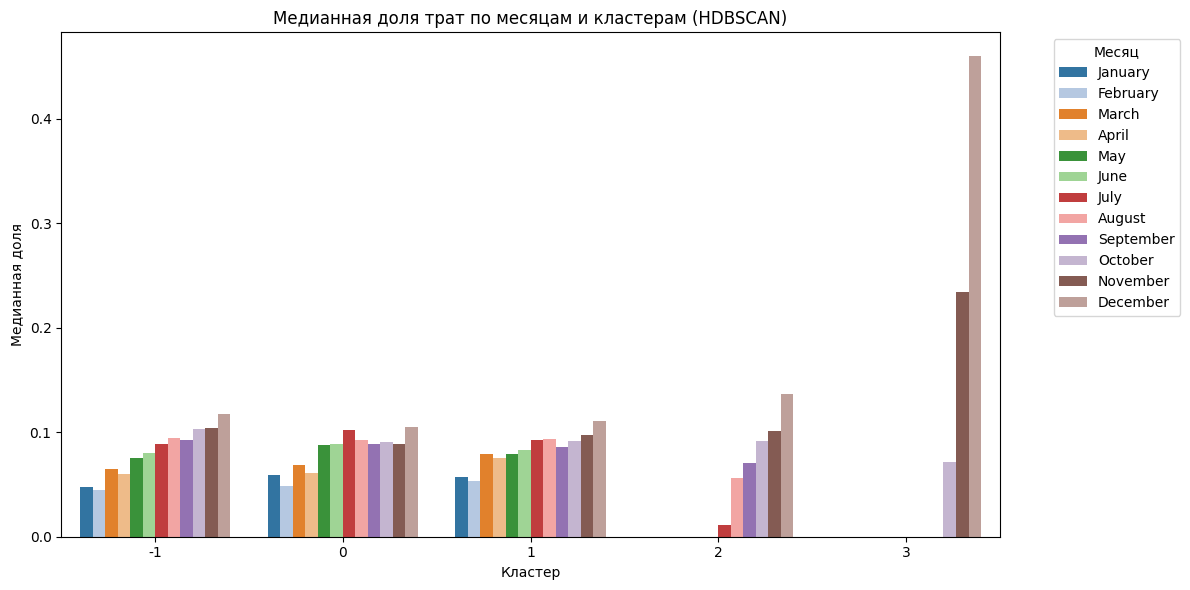

In [ ]:
# Шаг 1: Выбрать колонки, начинающиеся с 'share_month'
share_month = [col for col in H_df.columns if col.startswith('share_month')]

# Шаг 2: Группировка по кластеру и вычисление медиан
cluster_month = H_df.groupby('cluster')[share_month].median()

# Шаг 3: Переименование колонок — извлекаем только название месяца
cluster_month.columns = [col.split('_')[-1] for col in cluster_month.columns]

# Шаг 4: Преобразование в long формат
cluster_month_long = cluster_month.reset_index().melt(
    id_vars='cluster',
    var_name='month',
    value_name='median_share'
)

# Порядок месяцев
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Шаг 5: Преобразуем колонку month в категорию с заданным порядком
cluster_month_long['month'] = pd.Categorical(
    cluster_month_long['month'],
    categories=month_order,
    ordered=True
)

# Шаг 6: Построение barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cluster_month_long,
    x='cluster',
    y='median_share',
    hue='month',
    palette='tab20'
)

plt.title('Медианная доля трат по месяцам и кластерам (HDBSCAN)')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='Месяц', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## DBSCAN на основе эмбеддингов, полученных с помощью графовых нейронных сетей (GAT)
Этот код выполняет кластеризацию клиентов на основе графовой нейронной сети (GAT) и алгоритма DBSCAN. Сначала поведенческие признаки клиентов обрабатываются с помощью PCA и используются для построения kNN-графа с помощью FAISS. Каждый клиент представлен узлом графа, а связи между похожими — рёбрами. Затем граф проходит через GAT-энкодер, который обучается извлекать эмбеддинги клиентов.

Полученные представления подаются в DBSCAN, где перебираются гиперпараметры (eps, min_samples) и оценивается качество кластеризации. В качестве основной метрики используется Silhouette Score, так как он показывает, насколько чётко и раздельно сформированы кластеры, что особенно важно для DBSCAN с неизвестным числом кластеров. Лучшая конфигурация сохраняется и визуализируется с помощью UMAP.


➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=10
✅ Silhouette Score: 1.0000
📈 Calinski-Harabasz Index: 118600788825079808.00
📉 Davies-Bouldin Index: 0.0000

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=15
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=25
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=30
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=35
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=45
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=55
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.5, min_samples=60
❌ Недостаточно кластеров для оценки (меньше 3)

➡️ Testing: dim=32, dropout=0.2, eps=0.7, min_samples=10
❌ Недостаточно кластеров для оценки (меньш

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


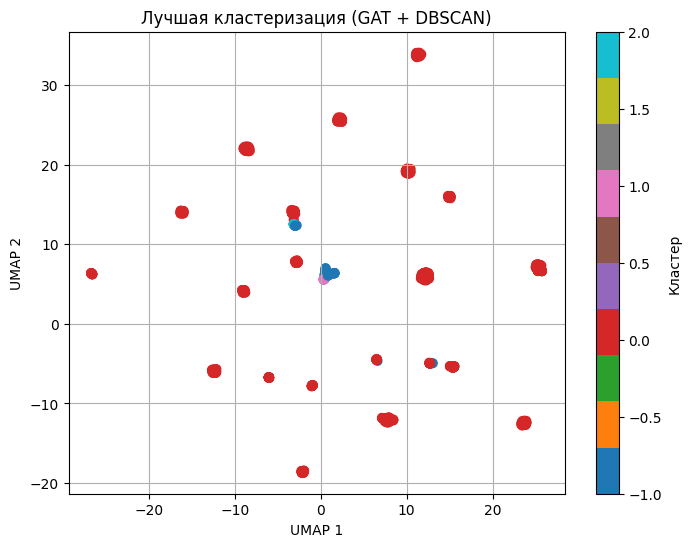

In [ ]:


# --- Подготовка данных ---
df_transformed_filled = df_transformed.copy()  # предполагается, что df_transformed уже определён

ids = df_transformed_filled['card_id'].values
features = df_transformed_filled.drop(columns='card_id').values.astype(np.float32)
x = torch.tensor(features, dtype=torch.float)

# --- PCA перед построением графа ---
pca = PCA(n_components=50)
features_reduced = pca.fit_transform(features)

# --- Функция построения kNN графа через FAISS ---
def build_knn_graph(features_np, k=10):
    index = faiss.IndexFlatL2(features_np.shape[1])
    index.add(features_np)
    distances, neighbors = index.search(features_np, k + 1)
    edge_index = []
    for i in range(features_np.shape[0]):
        for j in neighbors[i][1:]:  # exclude self
            edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

edge_index = build_knn_graph(features_reduced, k=10)
data = Data(x=x, edge_index=edge_index)

# --- Класс энкодера GAT ---
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=2, dropout=dropout)
        self.conv2 = GATConv(2 * out_channels * 2, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# --- Основной цикл перебора гиперпараметров ---
best_score = float('-inf')  # максимизируем Silhouette Score
best_params = {}
best_labels = None
best_embedding = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

for embedding_dim in [32, 64, 128]:
    for dropout_rate in [0.2, 0.3, 0.4]:
        for eps in [0.5, 0.7, 1.0]:
            for min_samples in [10,15,25, 30,35,45,55, 60]:
                print(f"\n➡️ Testing: dim={embedding_dim}, dropout={dropout_rate}, eps={eps}, min_samples={min_samples}")

                model = GATEncoder(in_channels=features.shape[1], out_channels=embedding_dim, dropout=dropout_rate).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

                model.train()
                for epoch in range(100):
                    optimizer.zero_grad()
                    z = model(data.x, data.edge_index)
                    loss = torch.norm(z, p=2)
                    loss.backward()
                    optimizer.step()

                model.eval()
                with torch.no_grad():
                    z = model(data.x, data.edge_index)
                z_np = z.cpu().numpy()

                # --- DBSCAN ---
                clusterer = DBSCAN(eps=eps, min_samples=min_samples)
                labels = clusterer.fit_predict(z_np)

                valid = labels != -1
                labels_valid = labels[valid]
                z_valid = z_np[valid]

                if len(set(labels_valid)) >= 3:
                    silhouette = silhouette_score(z_valid, labels_valid)
                    ch_score = calinski_harabasz_score(z_valid, labels_valid)
                    db_score = davies_bouldin_score(z_valid, labels_valid)

                    print(f"✅ Silhouette Score: {silhouette:.4f}")
                    print(f"📈 Calinski-Harabasz Index: {ch_score:.2f}")
                    print(f"📉 Davies-Bouldin Index: {db_score:.4f}")

                    if silhouette > best_score:
                        best_score = silhouette
                        best_params = {
                            "embedding_dim": embedding_dim,
                            "dropout": dropout_rate,
                            "eps": eps,
                            "min_samples": min_samples,
                            "Silhouette": silhouette,
                            "Calinski-Harabasz": ch_score,
                            "Davies-Bouldin": db_score
                        }
                        best_labels = labels
                        best_embedding = z_np
                else:
                    print("❌ Недостаточно кластеров для оценки (меньше 3)")

print("\n🏆 ЛУЧШИЕ ПАРАМЕТРЫ (по максимальному Silhouette Score):")
print(best_params)

# --- Сохраняем кластеризацию ---
cluster_df2 = pd.DataFrame({
    "card_id": ids,
    "cluster": best_labels
})

# --- Визуализация с UMAP ---
z_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(best_embedding)
plt.figure(figsize=(8, 6))
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=best_labels, cmap='tab10', s=40)
plt.title("Лучшая кластеризация (GAT + DBSCAN)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.colorbar(label='Кластер')
plt.show()


# Финальное описание кластеров клиентов по DBSCAN.

Кластер -1

Сегмент покупателя: "Консервативный Покупатель Повседневных Товаров"
Описание: Этот сегмент характеризуется сильным предпочтением к Bank's QR как основному типу кошелька, при этом фактические транзакции осуществляются преимущественно через бесконтактные (Contactless) методы и QR-коды. Пользователи этого кластера также совершают значительное количество онлайн-покупок (ECOM) и используют чиповые карты. Транзакции происходят со средней частотой (медианное время между транзакциями около 12 500 единиц) и относительно низким объемом трат, с небольшими пиками утром (7-8 часов) и вечером (19-20 часов). Подавляющая масса их трат (почти 90%) приходится на повседневные товары (daily_essentials). Наблюдается заметный рост медианной доли трат к концу года, достигая пика в ноябре и декабре. Можно предположить, что это пользователи, которые ценят удобство банковских приложений и бесконтактных платежей для рутинных, ежедневных покупок первой необходимости, и их потребительская активность возрастает в предпраздничный период.
Кластер 0

Сегмент покупателя: "Активный Потребитель Услуг"
Описание: Это самый активный и высокотратящий кластер. Пользователи очень часто совершают транзакции (самое низкое медианное время между транзакциями, около 5 500 единиц), преимущественно через Bank's QR и бесконтактные (Contactless) методы, с ярко выраженным утренним пиком активности (с 7 до 9 утра, до 9 млн единиц трат) и менее выраженным вечерним пиком. Их основные траты (около 40%) приходятся на различные услуги (services_other), а также на повседневные товары. Их потребительская активность распределена более равномерно в течение года, без резких сезонных всплесков. Можно предположить, что это люди, которые активно используют платежи на протяжении всего дня для широкого спектра нужд, особенно для услуг, возможно, связанных с бизнесом или насыщенным образом жизни, независимо от сезонных колебаний.
Кластер 1

Сегмент покупателя: "Онлайн-Энтузиаст и Сезонный Шопер"
Описание: Этот кластер явно ориентирован на онлайн-покупки (ECOM), составляющие почти 80% их транзакций. Они активно используют мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay), при этом доля Bank's QR крайне низка. Транзакции совершаются с относительно невысокой частотой (медианное время между транзакциями около 16 500 единиц) и средним объемом трат, с пиками в вечерние часы (19-20 часов). Их основные траты (около 45%) приходятся на различные услуги (services_other), а также на повседневные товары. Этот кластер демонстрирует наиболее выраженную сезонность в тратах, с резким ростом активности и самым высоким пиком среди всех кластеров в декабре (около 27%) и ноябре (около 20%). Вероятно, это пользователи, которые активно совершают онлайн-покупки, в том числе для предпраздничного шопинга или подготовки к Новому году.
Кластер 2

Сегмент покупателя: "Редкий Банковский Пользователь"
Описание: Этот сегмент состоит из пользователей, которые исключительно или почти исключительно используют платежи по QR-коду банка (100% медианной доли). При этом, как показывают POS-режимы, эти транзакции реализуются преимущественно через Chip (около 42%) и Contactless (около 40%) методы на терминалах, а не исключительно через прямое сканирование QR-кодов. Самая отличительная черта этого кластера — это очень низкая частота совершения транзакций (самое высокое медианное время между транзакциями, более 21 000 единиц) и самый низкий объем трат в течение дня, без ярко выраженных пиков. Основные траты приходятся на различные услуги (около 40%) и повседневные товары (около 30%). Наблюдается небольшой рост медианной доли трат к концу года. Возможно, это пользователи, которые совершают очень редкие, но необходимые покупки, используя при этом только банковские платежные методы, вероятно, для специфических нужд, не связанных с частым потреблением или онлайн-активностью, и их покупки немного возрастают в предпраздничный сезон.

In [ ]:
print(cluster_df2['cluster'].value_counts())
DB_df = final_df.merge(cluster_df2, on='card_id', how='left')

# Пример: ваш DataFrame с колонкой 'cluster'
DB_df['cluster_label'] = DB_df['cluster'].map({
    -1: "Шум / Неопределенные",
     0: "Активные Пользователи Банковских QR и Бесконтактных Платежей",
     1: "Онлайн-Шоперы",
     2: "Оффлайн Покупатели Повседневных Товаров",
     3: "Редкие, Консервативные Оффлайн-Покупатели"
})


cluster
 0    1937
-1      40
 2      12
 1      11
Name: count, dtype: int64


# Создаем графики и дескриптив статистику по кластерам.
Кластер -1:

Bank's QR имеет самую высокую медианную долю трат (около 42%).
Apple Pay имеет относительно низкую медианную долю (около 16%).
Google Pay и Samsung Pay имеют схожие и также относительно низкие медианные доли (около 15-16%).
Кластер 0:

Как и в Кластере -1, Bank's QR имеет самую высокую медианную долю трат (около 42%).
Apple Pay имеет медианную долю чуть выше, чем в Кластере -1 (около 18-19%).
Google Pay и Samsung Pay имеют схожие и низкие медианные доли (около 18%).
Кластер 1:

Этот кластер демонстрирует значительное изменение в структуре расходов.
Apple Pay, Google Pay и Samsung Pay все имеют относительно высокие и схожие медианные доли (около 29-30%).
Bank's QR имеет очень низкую медианную долю трат (около 5%).
Кластер 2:

Этот кластер доминирует Bank's QR, медианная доля трат которого составляет почти 100%.
Медианные доли для Apple Pay, Google Pay и Samsung Pay фактически равны нулю или незначительны в этом кластере.
Краткое описание кластеров:

Кластеры -1 и 0: Эти кластеры, по-видимому, характеризуются сильным предпочтением платежей через Bank's QR, при этом другие типы кошельков занимают гораздо меньшую долю.
Кластер 1: Этот кластер представляет пользователей, которые активно используют цифровые кошельки, такие как Apple Pay, Google Pay и Samsung Pay, при этом Bank's QR играет второстепенную роль.
Кластер 2: Этот кластер почти исключительно использует Bank's QR для транзакций, что указывает на сильную или единственную зависимость от этого метода оплаты в данной группе.

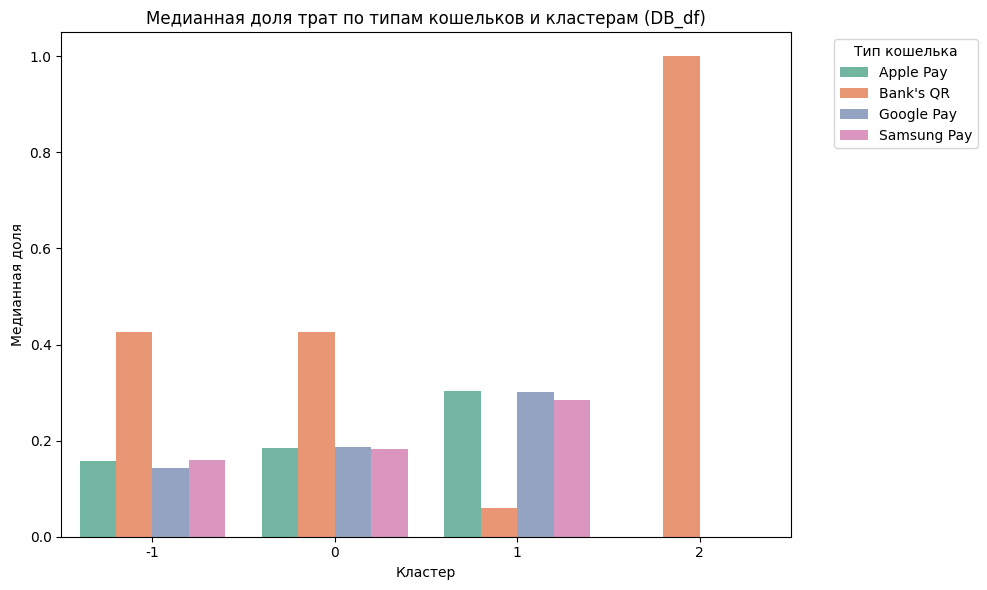

In [ ]:
# Шаг 1: Выбрать колонки, начинающиеся с 'share_wallet_type_spending_wallet_type_'
wallet_cols = [col for col in DB_df.columns if col.startswith('share_wallet_type_spending_wallet_type_')]

# Шаг 2: Группировка по кластеру и вычисление медиан
cluster_wallet = DB_df.groupby('cluster')[wallet_cols].median()

# Шаг 3: Переименование колонок — убираем префикс
prefix = 'share_wallet_type_spending_wallet_type_'
cluster_wallet.columns = [col.replace(prefix, '') for col in cluster_wallet.columns]

# Шаг 4: Преобразование в long формат
cluster_wallet_long = cluster_wallet.reset_index().melt(
    id_vars='cluster',
    var_name='wallet_type',
    value_name='median_share'
)

# Шаг 5: Построение barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_wallet_long,
    x='cluster',
    y='median_share',
    hue='wallet_type',
    palette='Set2'
)

plt.title('Медианная доля трат по типам кошельков и кластерам (DB_df)')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='Тип кошелька', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Обновленное описание кластеров:
Кластер -1:
* По типу кошелька: Доминирование Bank's QR (более 40% медианной доли трат). Мобильные платежи (Apple Pay, Google Pay, Samsung Pay) имеют низкие, но сравнимые доли (15-20%).
* По POS-режимам:
* Contactless и QR_Code имеют наибольшие доли трат, около 25-26%. Это хорошо согласуется с доминированием "Bank's QR" из первого графика, так как QR-коды часто используются для бесконтактных платежей.
* Chip и ECOM (онлайн-платежи) имеют меньшие, но заметные доли, около 17-19%.
* Swipe практически отсутствует.
* Объединенный вывод: Пользователи этого кластера предпочитают бесконтактные платежи (как через QR-коды банков, так и, возможно, через NFC), а также активно используют онлайн-покупки. Платежи через "Bank's QR" являются основным способом оплаты, но также присутствуют и другие методы.

Кластер 0:
* По типу кошелька: Аналогично кластеру -1, доминирование Bank's QR (более 40% медианной доли трат). Мобильные платежи (Apple Pay, Google Pay, Samsung Pay) также низкие, но немного выше, чем в кластере -1 (около 18-20%).
* По POS-режимам:
* Contactless снова является доминирующим режимом трат (около 29%), что подтверждает важность бесконтактных оплат.
* QR_Code также имеет высокую долю (около 25%), что также согласуется с первым графиком.
* Chip и ECOM имеют меньшие доли (около 18%).
* Swipe практически отсутствует.
* Объединенный вывод: Очень схож с кластером -1. Пользователи также активно используют бесконтактные платежи, в том числе через QR-коды банков. Незначительное увеличение доли мобильных платежей по сравнению с кластером -1. Это может быть группа, которая медленно переходит от традиционных методов к мобильным, но всё ещё сильно привязана к QR-кодам и бесконтакту.

Кластер 1:
* По типу кошелька: Здесь доминируют Apple Pay и Google Pay (около 30% каждая), а также Samsung Pay (около 28%). Bank's QR имеет очень низкую долю.
* По POS-режимам:
* ECOM (онлайн-коммерция) является подавляющим режимом трат, составляя почти 80% медианной доли.
* Доли Chip, Contactless, QR_Code и Swipe очень низкие (менее 10%).
* Объединенный вывод: Это кластер онлайн-покупателей. Пользователи активно используют мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay), что логично для онлайн-транзакций, так как эти системы часто интегрированы в процессы онлайн-оплаты. Они практически не используют физические POS-терминалы или QR-коды для оффлайн-покупок.

Кластер 2:
* По типу кошелька: Абсолютное доминирование Bank's QR (100% медианной доли трат). Другие типы кошельков не используются.
* По POS-режимам:
* Chip и Contactless являются доминирующими режимами трат, с долями около 40-42%.
* QR_Code имеет значительно меньшую долю (около 16%).
* ECOM и Swipe отсутствуют или их доля крайне мала.
* Объединенный вывод: Этот сегмент состоит из пользователей, которые исключительно или почти исключительно используют платежи по QR-коду банка (как показано на первом графике). Однако, второй график показывает, что эти платежи реализуются преимущественно через Chip и Contactless режимы на POS-терминалах, а не исключительно через сканирование QR-кодов в явном виде. Это может означать, что "Bank's QR" здесь является общим названием для банковских транзакций, которые могут быть реализованы через чип-карты или бесконтактные терминалы, возможно, с привязкой к банковским приложениям, которые могут также включать QR-функционал, но не как основной способ взаимодействия с терминалом.

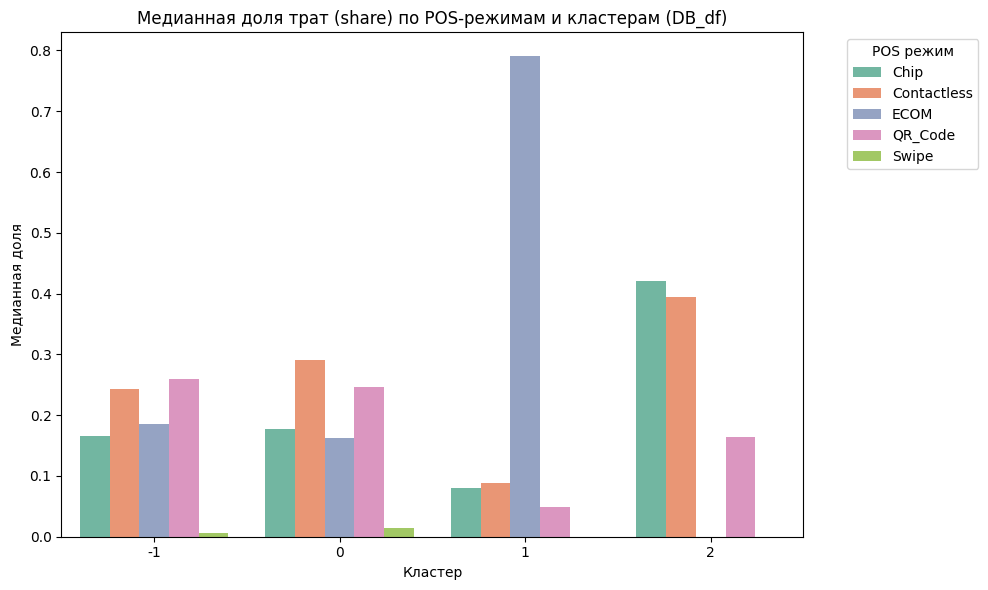

In [ ]:
# Шаг 1: Выбрать колонки, начинающиеся с 'share_pos_entry_mode_spending_pos_entry_mode_'
pos_share_cols = [col for col in DB_df.columns if col.startswith('share_pos_entry_mode_spending_pos_entry_mode_')]

# Шаг 2: Группировка по кластеру и вычисление медиан
cluster_pos_share = DB_df.groupby('cluster')[pos_share_cols].median()

# Шаг 3: Переименование колонок — убираем префикс
prefix = 'share_pos_entry_mode_spending_pos_entry_mode_'
cluster_pos_share.columns = [col.replace(prefix, '') for col in cluster_pos_share.columns]

# Шаг 4: Преобразование в long формат
cluster_pos_share_long = cluster_pos_share.reset_index().melt(
    id_vars='cluster',
    var_name='pos_entry_mode',
    value_name='median_share'
)

# Шаг 5: Построение barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_pos_share_long,
    x='cluster',
    y='median_share',
    hue='pos_entry_mode',
    palette='Set2'
)

plt.title('Медианная доля трат (share) по POS-режимам и кластерам (DB_df)')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='POS режим', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Кластер -1:

По типу кошелька: Доминирование Bank's QR (более 40% медианной доли трат). Мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay) имеют значительно меньшие, но сравнимые доли (около 15-20% каждая), при этом Samsung Pay имеет небольшое преимущество.
По POS-режимам: Наибольшие доли трат приходятся на Contactless (примерно 25%) и QR_Code (около 26%). Также заметны доли у Chip (около 17%) и ECOM (онлайн-платежи, около 19%). Доля Swipe практически отсутствует.
По времени между транзакциями: Медианное время между транзакциями составляет около 12 500 единиц (вероятно, минут или часов, исходя из масштаба графика). Это средний показатель по сравнению с другими кластерами.
Объединенный вывод: Этот кластер характеризуется сильным предпочтением к Bank's QR как основному типу кошелька, при этом фактические транзакции осуществляются преимущественно через бесконтактные (Contactless) методы и QR-коды. Пользователи этого кластера также совершают значительное количество онлайн-покупок (ECOM) и используют чиповые карты. Транзакции происходят со средней частотой. Можно предположить, что это пользователи, которые ценят удобство банковских приложений и бесконтактных платежей в оффлайн-среде и совершают покупки со средней периодичностью.
Кластер 0:

По типу кошелька: Как и в кластере -1, Bank's QR является доминирующим типом кошелька с медианной долей более 40%. Доли Apple Pay, Google Pay и Samsung Pay несколько выше, чем в кластере -1 (около 18-20% каждая), но все еще значительно ниже Bank's QR.
По POS-режимам: Contactless остается доминирующим режимом (около 29%), а QR_Code также имеет высокую долю (около 25%). Chip и ECOM имеют меньшие доли (около 18% каждая). Swipe практически отсутствует.
По времени между транзакциями: Этот кластер имеет самое низкое медианное время между транзакциями, около 5 500 единиц. Это указывает на высокую частоту совершения транзакций.
Объединенный вывод: Очень схож с кластером -1 в плане предпочтений к Bank's QR и использованию бесконтактных и QR-кодовых платежей в оффлайн-среде. Однако, пользователи в этом кластере показывают немного большую открытость к использованию мобильных платежных систем (Apple Pay, Google Pay, Samsung Pay) и, что самое главное, совершают транзакции значительно чаще, чем пользователи других кластеров. Это может быть группа активных покупателей, которые часто используют основные методы оплаты.
Кластер 1:

По типу кошелька: Этот кластер демонстрирует явное предпочтение мобильным платежным системам: Apple Pay и Google Pay имеют медианные доли около 30% каждая, а Samsung Pay — около 28%. Доля Bank's QR крайне низка (менее 10%).
По POS-режимам: ECOM (онлайн-коммерция) является подавляющим режимом трат, составляя почти 80% медианной доли. Доли Chip, Contactless, QR_Code и Swipe очень низкие (менее 10% каждая).
По времени между транзакциями: Медианное время между транзакциями составляет около 16 500 единиц, что является вторым по величине показателем.
Объединенный вывод: Это кластер, ориентированный на онлайн-покупки (ECOM). Пользователи активно используют мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay) для подавляющего большинства своих транзакций, которые при этом совершаются с относительно невысокой частотой (большое время между транзакциями). Они практически не используют физические POS-терминалы или QR-коды для оффлайн-покупок.
Кластер 2:

По типу кошелька: В этом сегменте наблюдается абсолютное доминирование Bank's QR с медианной долей трат в 100%. Остальные типы кошельков (Apple Pay, Google Pay, Samsung Pay) не используются или их доля настолько мала, что не отображается.
По POS-режимам: Chip и Contactless являются доминирующими режимами трат, с долями около 42% и 40% соответственно. Доля QR_Code значительно ниже (около 16%). ECOM и Swipe отсутствуют или их доля крайне мала.
По времени между транзакциями: Этот кластер имеет самое высокое медианное время между транзакциями, более 21 000 единиц. Это указывает на очень низкую частоту совершения транзакций.
Объединенный вывод: Этот сегмент состоит из пользователей, которые исключительно или почти исключительно используют платежи по QR-коду банка. При этом, как показывают POS-режимы, эти транзакции реализуются преимущественно через Chip и Contactless методы на терминалах, а не исключительно через прямое сканирование QR-кодов. Самая отличительная черта этого кластера — это очень низкая частота совершения транзакций. Возможно, это пользователи, которые совершают крупные, но редкие покупки или используют банковские платежи в очень специфических ситуациях./

<ipython-input-87-fc8b6c4f6d8c>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
<ipython-input-87-fc8b6c4f6d8c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


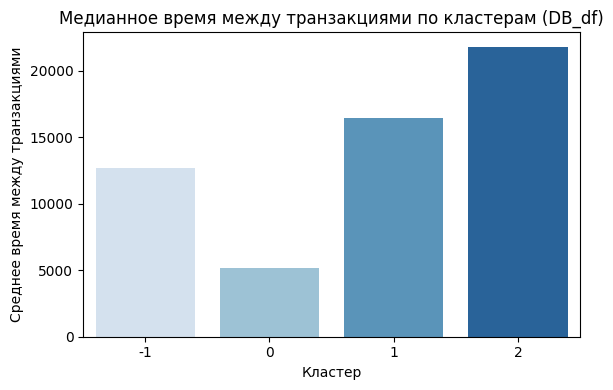

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(
    data=DB_df,
    x='cluster',
    y='avg_time_between_txn',
    estimator='median',
    ci=None,
    palette='Blues'
)
plt.title('Медианное время между транзакциями по кластерам (DB_df)')
plt.xlabel('Кластер')
plt.ylabel('Среднее время между транзакциями')
plt.tight_layout()
plt.show()


In [ ]:
DB_df[['share_foreign_txn', 'share_converted_txn']].describe()


,share_foreign_txn,share_converted_txn
count,2000.000000,2000.000000
mean,0.000646,0.000646
std,0.001892,0.001892
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000491,0.000491
max,0.022727,0.022727


In [ ]:
# 1. Медианы по колонкам, начинающимся с 'share_', но не начинающимся с 'share_hour_'
share_columns = [col for col in DB_df.columns if col.startswith('share_') and not col.startswith('share_hour_')]
cluster_medians_share = DB_df.groupby('cluster')[share_columns].median()

# 2. Медианы по всем колонкам, начинающимся с 'share_hour_'
share_hour_columns = [col for col in DB_df.columns if col.startswith('share_hour_')]
cluster_medians_hour = DB_df.groupby('cluster')[share_hour_columns].median() if share_hour_columns else None

# Вывод
cluster_medians_share.columns




Index(['share_day_name_spending_day_name_Friday',
       'share_day_name_spending_day_name_Monday',
       'share_day_name_spending_day_name_Saturday',
       'share_day_name_spending_day_name_Sunday',
       'share_day_name_spending_day_name_Thursday',
       'share_day_name_spending_day_name_Tuesday',
       'share_day_name_spending_day_name_Wednesday',
       'share_month_name_spending_month_name_April',
       'share_month_name_spending_month_name_August',
       'share_month_name_spending_month_name_December',
       'share_month_name_spending_month_name_February',
       'share_month_name_spending_month_name_January',
       'share_month_name_spending_month_name_July',
       'share_month_name_spending_month_name_June',
       'share_month_name_spending_month_name_March',
       'share_month_name_spending_month_name_May',
       'share_month_name_spending_month_name_November',
       'share_month_name_spending_month_name_October',
       'share_month_name_spending_month_name_Sept

Кластер -1:

По типу кошелька: Доминирование Bank's QR (более 40% медианной доли трат). Мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay) имеют значительно меньшие, но сравнимые доли (около 15-20% каждая), при этом Samsung Pay имеет небольшое преимущество.
По POS-режимам: Наибольшие доли трат приходятся на Contactless (примерно 25%) и QR_Code (около 26%). Также заметны доли у Chip (около 17%) и ECOM (онлайн-платежи, около 19%). Доля Swipe практически отсутствует.
По времени между транзакциями: Медианное время между транзакциями составляет около 12 500 единиц, что является средним показателем по сравнению с другими кластерами.
Среднее значение трат по часам: Уровень трат относительно низкий. Есть небольшой пик в районе 7-8 утра и еще один, более выраженный, но все равно невысокий, около 19-20 часов. В целом, дневная активность распределена достаточно равномерно, но с понижением в ночное время.
Объединенный вывод: Этот кластер характеризуется сильным предпочтением к Bank's QR как основному типу кошелька, при этом фактические транзакции осуществляются преимущественно через бесконтактные (Contactless) методы и QR-коды. Пользователи этого кластера также совершают значительное количество онлайн-покупок (ECOM) и используют чиповые карты. Транзакции происходят со средней частотой и относительно низким объемом трат, с небольшими пиками утром и вечером. Можно предположить, что это пользователи, которые ценят удобство банковских приложений и бесконтактных платежей в оффлайн-среде для повседневных, но не очень крупных покупок.
Кластер 0:

По типу кошелька: Как и в кластере -1, Bank's QR является доминирующим типом кошелька с медианной долей более 40%. Доли Apple Pay, Google Pay и Samsung Pay несколько выше, чем в кластере -1 (около 18-20% каждая), но все еще значительно ниже Bank's QR.
По POS-режимам: Contactless остается доминирующим режимом (около 29%), а QR_Code также имеет высокую долю (около 25%). Chip и ECOM имеют меньшие доли (около 18% каждая). Swipe практически отсутствует.
По времени между транзакциями: Этот кластер имеет самое низкое медианное время между транзакциями, около 5 500 единиц. Это указывает на очень высокую частоту совершения транзакций.
Среднее значение трат по часам: Этот кластер демонстрирует наиболее высокий уровень трат, значительно превосходящий все остальные кластеры. У него ярко выраженный пик активности в утренние часы (с 7 до 9 утра), достигающий почти 9 миллионов единиц (возможно, рублей или других денежных единиц). Затем наблюдается спад, но уровень остается относительно высоким до 14-15 часов, после чего снова возрастает к вечернему пику (19-20 часов), хотя и менее выраженному, чем утренний. Ночью активность минимальна.
Объединенный вывод: Этот кластер является группой наиболее активных и высокотратящих пользователей. Они очень часто совершают транзакции, преимущественно через Bank's QR и бесконтактные методы, с ярко выраженной утренней и вечерней активностью. Несмотря на то, что они также используют ECOM и Chip, их предпочтения явно смещены в сторону оффлайн-платежей с использованием банковских систем. Можно предположить, что это люди, которые активно используют платежи на протяжении всего дня, возможно, для рабочих нужд или ежедневных крупных покупок.
Кластер 1:

По типу кошелька: Этот кластер демонстрирует явное предпочтение мобильным платежным системам: Apple Pay и Google Pay имеют медианные доли около 30% каждая, а Samsung Pay — около 28%. Доля Bank's QR крайне низка (менее 10%).
По POS-режимам: ECOM (онлайн-коммерция) является подавляющим режимом трат, составляя почти 80% медианной доли. Доли Chip, Contactless, QR_Code и Swipe очень низкие (менее 10% каждая).
По времени между транзакциями: Медианное время между транзакциями составляет около 16 500 единиц, что является вторым по величине показателем.
Среднее значение трат по часам: Уровень трат этого кластера находится на среднем уровне. Наблюдается постепенный рост активности с утра до 8-9 часов, затем снижение, после чего идет более плавный, но стабильный рост в течение дня, с пиком в вечерние часы (19-20 часов). Ночью активность минимальна.
Объединенный вывод: Это кластер, ориентированный на онлайн-покупки (ECOM). Пользователи активно используют мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay) для подавляющего большинства своих транзакций. Эти транзакции совершаются с относительно невысокой частотой (большое время между транзакциями) и средним объемом трат, с пиками в вечернее время. Вероятно, это пользователи, которые предпочитают совершать покупки онлайн, возможно, после работы или в свободное время, и не так часто прибегают к оффлайн-платежам.
Кластер 2:

По типу кошелька: В этом сегменте наблюдается абсолютное доминирование Bank's QR с медианной долей трат в 100%. Остальные типы кошельков (Apple Pay, Google Pay, Samsung Pay) не используются или их доля настолько мала, что не отображается.
По POS-режимам: Chip и Contactless являются доминирующими режимами трат, с долями около 42% и 40% соответственно. Доля QR_Code значительно ниже (около 16%). ECOM и Swipe отсутствуют или их доля крайне мала.
По времени между транзакциями: Этот кластер имеет самое высокое медианное время между транзакциями, более 21 000 единиц. Это указывает на очень низкую частоту совершения транзакций.
Среднее значение трат по часам: Уровень трат этого кластера самый низкий среди всех. Активность в течение дня очень низкая и относительно равномерная, без ярко выраженных пиков, с небольшим увеличением в дневное время (примерно с 8 до 16 часов).
Объединенный вывод: Этот сегмент состоит из пользователей, которые исключительно или почти исключительно используют платежи по QR-коду банка. При этом, как показывают POS-режимы, эти транзакции реализуются преимущественно через Chip и Contactless методы на терминалах, а не исключительно через прямое сканирование QR-кодов. Самая отличительная черта этого кластера — это очень низкая частота совершения транзакций и самый низкий объем трат в течение дня. Возможно, это пользователи, которые совершают очень редкие, но необходимые покупки, используя при этом только банковские платежные методы.

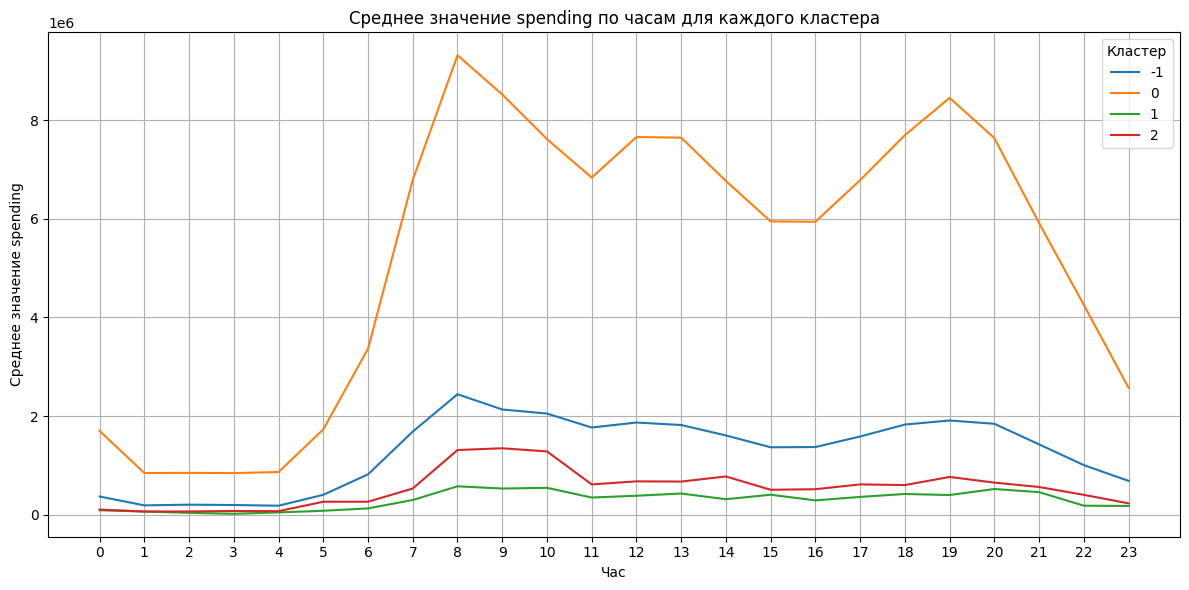

In [ ]:
# Выбираем колонки с нужным префиксом и колонку 'cluster'
cols = [col for col in DB_df.columns if col.startswith('spending_hour_') or col == 'cluster']

# Создаем датафрейм с этими колонками
selected_df = DB_df[cols].copy()

# Преобразуем из wide в long, используя 'cluster' как id_var
df_long = selected_df.melt(id_vars='cluster', var_name='hour', value_name='value')
df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

# Очистка названий часов от префикса
prefix = 'spending_hour_'
df_long['hour'] = df_long['hour'].str.replace(prefix, '', regex=False).str.strip('_')

# Приводим колонку 'hour' к числовому типу для корректного отображения по оси X
df_long['hour'] = pd.to_numeric(df_long['hour'], errors='coerce')

grouped = df_long.groupby(['cluster', 'hour'])['value'].mean().reset_index()

# Построение line-графика
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped, x='hour', y='value', hue='cluster', palette='tab10')

plt.title('Среднее значение spending по часам для каждого кластера')
plt.xlabel('Час')
plt.ylabel('Среднее значение spending')
plt.xticks(range(0, 24))  # если часы идут от 0 до 23
plt.grid(True)
plt.legend(title='Кластер')
plt.tight_layout()
plt.show()

In [ ]:
# Отбираем колонки, начинающиеся с 'share_mcc_category'
share_mcc_columns = [col for col in DB_df.columns if col.startswith('share_mcc_category')]

# Группируем по 'cluster' и считаем медиану только по этим колонкам
cluster_medians_mcc = DB_df.groupby('cluster')[share_mcc_columns].median()

# Вывод результата
cluster_medians_mcc.columns


Index(['share_mcc_category_spending_mcc_category_Clothing & Apparel',
       'share_mcc_category_spending_mcc_category_Dining & Restaurants',
       'share_mcc_category_spending_mcc_category_Electronics & Software',
       'share_mcc_category_spending_mcc_category_Fuel & Service Stations',
       'share_mcc_category_spending_mcc_category_General Retail & Department',
       'share_mcc_category_spending_mcc_category_Grocery & Food Markets',
       'share_mcc_category_spending_mcc_category_Hobby, Books, Sporting Goods',
       'share_mcc_category_spending_mcc_category_Home Furnishings & Supplies',
       'share_mcc_category_spending_mcc_category_Pharmacies & Health',
       'share_mcc_category_spending_mcc_category_Services (Other)',
       'share_mcc_category_spending_mcc_category_Travel & Transportation',
       'share_mcc_category_spending_mcc_category_Unknown',
       'share_mcc_category_spending_mcc_category_Utilities & Bill Payments'],
      dtype='object')

## 💳 1. Повседневные покупки (Daily Essentials)
- Grocery & Food Markets  
- Pharmacies & Health  
- Utilities & Bill Payments  

## 🛍 2. Розничная торговля и мода (Retail & Apparel)
- Clothing & Apparel  
- General Retail & Department  
- Home Furnishings & Supplies  

## 🍽 3. Еда и рестораны (Dining)
- Dining & Restaurants  

## ⛽ 4. Транспорт и топливо (Transport & Fuel)
- Fuel & Service Stations  
- Travel & Transportation  

## 💻 5. Электроника и хобби (Electronics & Leisure)
- Electronics & Software  
- Hobby, Books, Sporting Goods  

## 🛠 6. Услуги и прочее (Services & Other)
- Services (Other)  
- Unknown  


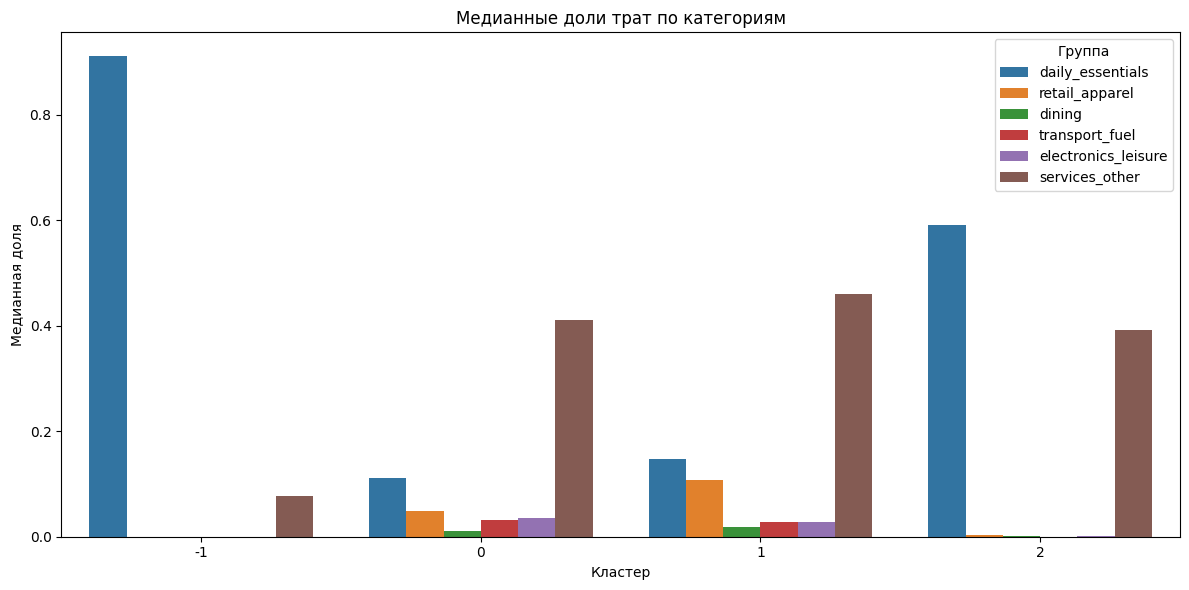

In [ ]:


# Предполагаем, что cluster_medians_mcc - это твой DataFrame с исходными данными

# Создаем агрегированные колонки по группам
for group_name, columns in grouped_mcc_columns.items():
    cluster_medians_mcc[group_name] = cluster_medians_mcc[columns].sum(axis=1)

# Если 'cluster' — индекс, переводим в столбец
if cluster_medians_mcc.index.name == 'cluster' or 'cluster' not in cluster_medians_mcc.columns:
    cluster_medians_mcc = cluster_medians_mcc.reset_index()

cols = list(grouped_mcc_columns.keys())  # ['daily_essentials', 'retail_apparel', ... ]

# Преобразуем в длинный формат
df_long = cluster_medians_mcc.melt(id_vars='cluster',
                                   value_vars=cols,
                                   var_name='category',
                                   value_name='value')

# Строим barplot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_long, x='cluster', y='value', hue='category')

plt.title('Медианные доли трат по категориям')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='Группа')
plt.xticks(rotation=0)  # Обычно кластеры — числа, можно не крутить
plt.tight_layout()
plt.show()


Кластер -1

Сегмент покупателя: "Консервативный Покупатель Повседневных Товаров"
Описание: Этот сегмент характеризуется сильным предпочтением к Bank's QR как основному типу кошелька, при этом фактические транзакции осуществляются преимущественно через бесконтактные (Contactless) методы и QR-коды. Пользователи этого кластера также совершают значительное количество онлайн-покупок (ECOM) и используют чиповые карты. Транзакции происходят со средней частотой (медианное время между транзакциями около 12 500 единиц) и относительно низким объемом трат, с небольшими пиками утром (7-8 часов) и вечером (19-20 часов). Подавляющая масса их трат (почти 90%) приходится на повседневные товары (daily_essentials). Наблюдается заметный рост медианной доли трат к концу года, достигая пика в ноябре и декабре. Можно предположить, что это пользователи, которые ценят удобство банковских приложений и бесконтактных платежей для рутинных, ежедневных покупок первой необходимости, и их потребительская активность возрастает в предпраздничный период.
Кластер 0

Сегмент покупателя: "Активный Потребитель Услуг"
Описание: Это самый активный и высокотратящий кластер. Пользователи очень часто совершают транзакции (самое низкое медианное время между транзакциями, около 5 500 единиц), преимущественно через Bank's QR и бесконтактные (Contactless) методы, с ярко выраженным утренним пиком активности (с 7 до 9 утра, до 9 млн единиц трат) и менее выраженным вечерним пиком. Их основные траты (около 40%) приходятся на различные услуги (services_other), а также на повседневные товары. Их потребительская активность распределена более равномерно в течение года, без резких сезонных всплесков. Можно предположить, что это люди, которые активно используют платежи на протяжении всего дня для широкого спектра нужд, особенно для услуг, возможно, связанных с бизнесом или насыщенным образом жизни, независимо от сезонных колебаний.
Кластер 1

Сегмент покупателя: "Онлайн-Энтузиаст и Сезонный Шопер"
Описание: Этот кластер явно ориентирован на онлайн-покупки (ECOM), составляющие почти 80% их транзакций. Они активно используют мобильные платежные системы (Apple Pay, Google Pay, Samsung Pay), при этом доля Bank's QR крайне низка. Транзакции совершаются с относительно невысокой частотой (медианное время между транзакциями около 16 500 единиц) и средним объемом трат, с пиками в вечерние часы (19-20 часов). Их основные траты (около 45%) приходятся на различные услуги (services_other), а также на повседневные товары. Этот кластер демонстрирует наиболее выраженную сезонность в тратах, с резким ростом активности и самым высоким пиком среди всех кластеров в декабре (около 27%) и ноябре (около 20%). Вероятно, это пользователи, которые активно совершают онлайн-покупки, в том числе для предпраздничного шопинга или подготовки к Новому году.
Кластер 2

Сегмент покупателя: "Редкий Банковский Пользователь"
Описание: Этот сегмент состоит из пользователей, которые исключительно или почти исключительно используют платежи по QR-коду банка (100% медианной доли). При этом, как показывают POS-режимы, эти транзакции реализуются преимущественно через Chip (около 42%) и Contactless (около 40%) методы на терминалах, а не исключительно через прямое сканирование QR-кодов. Самая отличительная черта этого кластера — это очень низкая частота совершения транзакций (самое высокое медианное время между транзакциями, более 21 000 единиц) и самый низкий объем трат в течение дня, без ярко выраженных пиков. Основные траты приходятся на различные услуги (около 40%) и повседневные товары (около 30%). Наблюдается небольшой рост медианной доли трат к концу года. Возможно, это пользователи, которые совершают очень редкие, но необходимые покупки, используя при этом только банковские платежные методы, вероятно, для специфических нужд, не связанных с частым потреблением или онлайн-активностью, и их покупки немного возрастают в предпраздничный сезон.

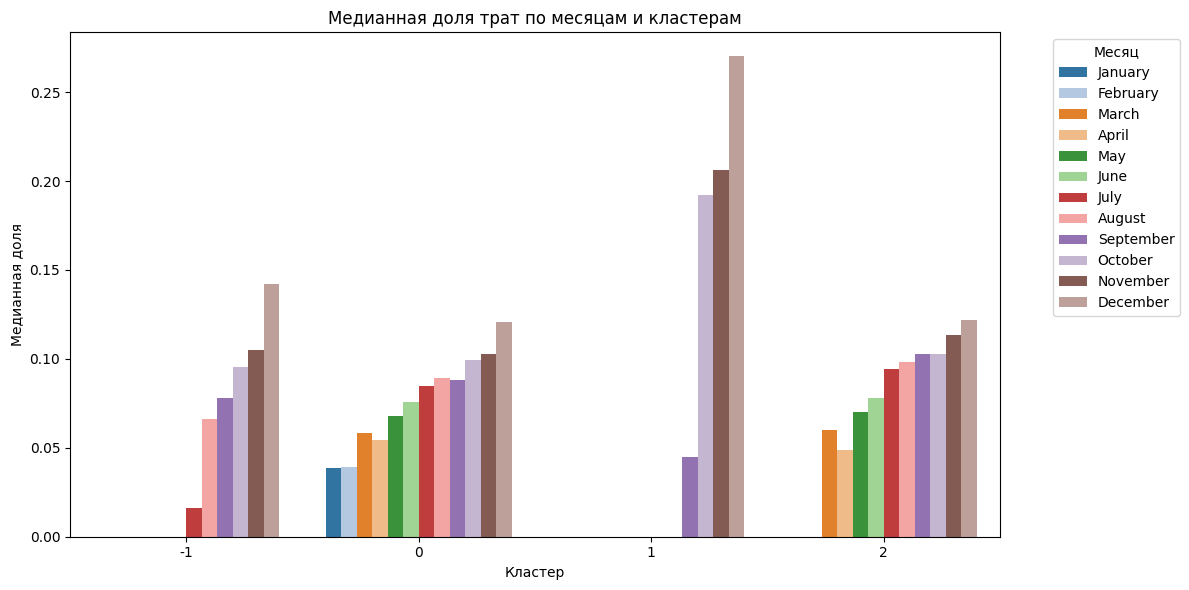

In [ ]:
share_month = [col for col in DB_df.columns if col.startswith('share_month')]

cluster_month = DB_df.groupby('cluster')[share_month].median()

cluster_month
# Шаг 1: Выбрать колонки, начинающиеся с 'share_month'
share_month = [col for col in DB_df.columns if col.startswith('share_month')]

# Шаг 2: Группировка по кластеру и вычисление медиан
cluster_month = DB_df.groupby('cluster')[share_month].median()

# Шаг 3: Переименование колонок — извлекаем только название месяца
cluster_month.columns = [col.split('_')[-1] for col in cluster_month.columns]

# Шаг 4: Преобразование в long формат
cluster_month_long = cluster_month.reset_index().melt(id_vars='cluster',
                                                       var_name='month',
                                                       value_name='median_share')

# Результат
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Преобразуем колонку month в категориальный тип с нужным порядком
cluster_month_long['month'] = pd.Categorical(cluster_month_long['month'], categories=month_order, ordered=True)

# Построение barplot: месяц — цвет
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_month_long, x='cluster', y='median_share', hue='month', palette='tab20')

plt.title('Медианная доля трат по месяцам и кластерам')
plt.xlabel('Кластер')
plt.ylabel('Медианная доля')
plt.legend(title='Месяц', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-56-d637160d770a>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


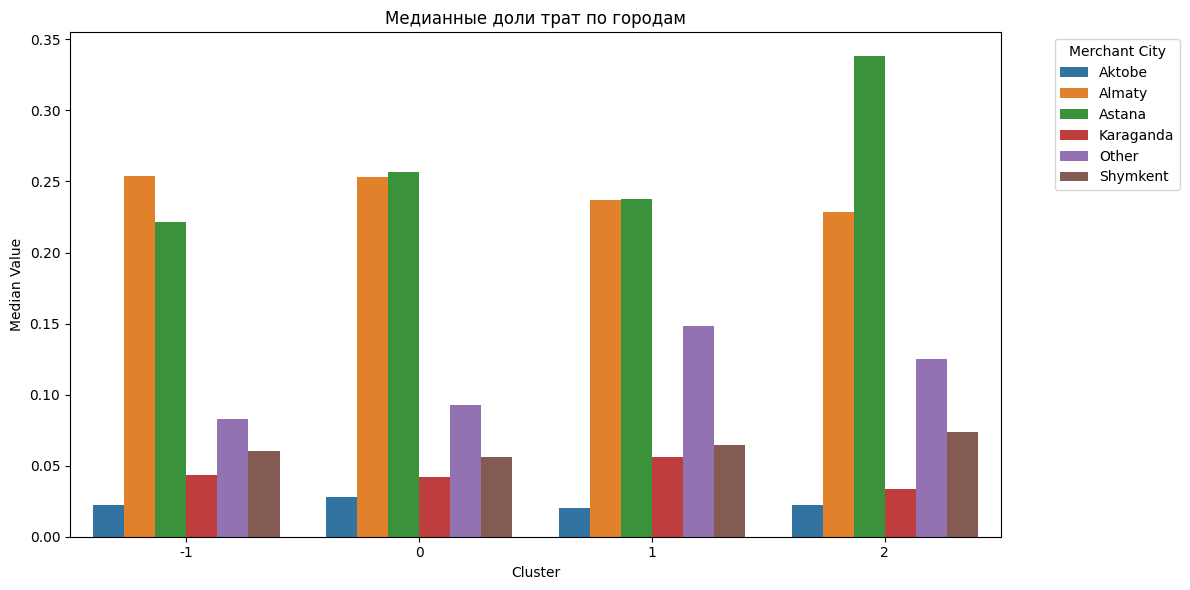

In [ ]:
# Выбираем колонки с нужным префиксом
cols = [col for col in DB_df.columns if col.startswith('share_merchant_city_spending_merchant_city')]

# Создаем датафрейм с этими колонками
selected_df = DB_df[cols].copy()

# Переименовываем колонки — убираем префикс
prefix = 'share_merchant_city_spending_merchant_city'
new_col_names = [col.replace(prefix, '') for col in cols]
selected_df.columns = new_col_names

# Преобразуем из wide в long
df_long = selected_df.reset_index().melt(id_vars='index', var_name='merchant_city', value_name='value')

# Очистка названий городов от лишних символов (например, подчеркиваний)
df_long['merchant_city'] = df_long['merchant_city'].str.strip('_').str.strip()

# Добавляем колонку cluster, используя индекс
# 'index' здесь — это исходный индекс из DB_df
df_long['cluster'] = DB_df.loc[df_long['index'], 'cluster'].values

# Можно убрать временный индекс после добавления
df_long = df_long.drop(columns='index')

# Группируем и считаем медиану
median_by_cluster_city = df_long.groupby(['cluster', 'merchant_city'])['value'].median().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=median_by_cluster_city,
    x='cluster',
    y='value',
    hue='merchant_city',
    ci=None  # убирает отображение доверительного интервала
)

plt.title('Медианные доли трат по городам')
plt.ylabel('Median Value')
plt.xlabel('Cluster')
plt.legend(title='Merchant City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-59-fc714cbbf253>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


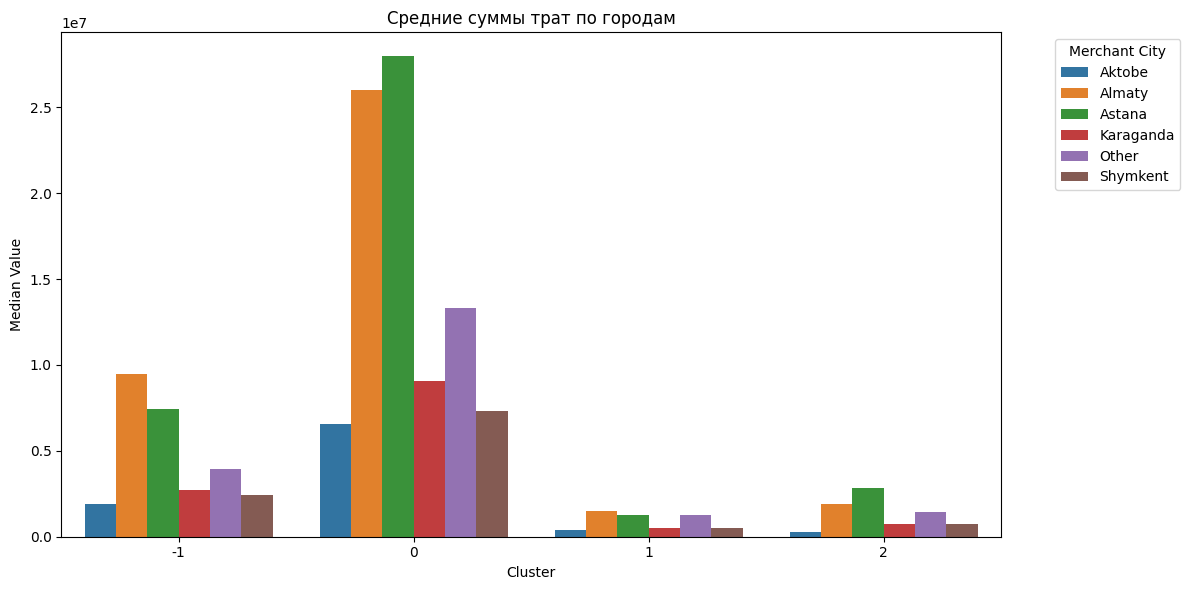

In [ ]:
# Выбираем колонки с нужным префиксом
prefix = 'spending_merchant_city'
cols = [col for col in DB_df.columns if col.startswith(prefix)]

# Создаем датафрейм с этими колонками
selected_df = DB_df[cols].copy()

# Переименовываем колонки — убираем префикс
new_col_names = [col.replace(prefix, '') for col in cols]
selected_df.columns = new_col_names

# Преобразуем из wide в long
df_long = selected_df.reset_index().melt(id_vars='index', var_name='merchant_city', value_name='value')

# Очистка названий городов от лишних символов (например, подчеркиваний)
df_long['merchant_city'] = df_long['merchant_city'].str.strip('_').str.strip()

# Добавляем колонку cluster, используя индекс
df_long['cluster'] = DB_df.loc[df_long['index'], 'cluster'].values

# Удаляем временный индекс
df_long = df_long.drop(columns='index')

# Группируем и считаем медиану
median_by_cluster_city = df_long.groupby(['cluster', 'merchant_city'])['value'].mean().reset_index()

# Построение графика
plt.figure(figsize=(12, 6))
sns.barplot(
    data=median_by_cluster_city,
    x='cluster',
    y='value',
    hue='merchant_city',
    ci=None
)

plt.title('Средние суммы трат по городам')
plt.ylabel('Median Value')
plt.xlabel('Cluster')
plt.legend(title='Merchant City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
-1,990.0,4643124.055505,8894497.18844,0.0,379971.6925,1525220.215,4994806.4325,96849350.91
0,10770.0,15035394.86624,33160472.804189,0.0,983800.685,4326553.99,14325207.62,834520781.87
1,132.0,896616.607273,1108058.568252,0.0,155934.4025,495604.54,1241978.33,5821657.15
2,108.0,1328677.729722,1441911.404057,0.0,263248.8525,827123.09,1729203.2,6695608.3


## Spectral Clustering
### Spectral Clustering - эта модель не продемонстрировала хорошего перформанса по метрикам, по этой причине мы не делали разбор на кластеры от этой модели.


➡️ Testing: dim=32, dropout=0.2, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.1152
📈 Calinski-Harabasz Index: 0.74
📉 Davies-Bouldin Index: 1.9975

➡️ Testing: dim=32, dropout=0.2, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.3428
📈 Calinski-Harabasz Index: 627.97
📉 Davies-Bouldin Index: 1.6592

➡️ Testing: dim=32, dropout=0.2, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.4227
📈 Calinski-Harabasz Index: 2.88
📉 Davies-Bouldin Index: 2.3336

➡️ Testing: dim=32, dropout=0.2, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.1636
📈 Calinski-Harabasz Index: 34883030220800.00
📉 Davies-Bouldin Index: 4.4279

➡️ Testing: dim=32, dropout=0.3, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.2975
📈 Calinski-Harabasz Index: 0.95
📉 Davies-Bouldin Index: 1.9961

➡️ Testing: dim=32, dropout=0.3, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.5063
📈 Calinski-Harabasz Index: 0.18
📉 Davies-Bouldin Index: 3.9682

➡️ Testing: dim=32, dropout=0.3, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0434
📈 Calinski-Harabasz Index: 19.78
📉 Davies-Bouldin Index: 1.8857

➡️ Testing: dim=32, dropout=0.3, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.1884
📈 Calinski-Harabasz Index: 24.32
📉 Davies-Bouldin Index: 3.5332

➡️ Testing: dim=32, dropout=0.4, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.5363
📈 Calinski-Harabasz Index: 0.79
📉 Davies-Bouldin Index: 1.9964

➡️ Testing: dim=32, dropout=0.4, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0177
📈 Calinski-Harabasz Index: 15.36
📉 Davies-Bouldin Index: 12.4004

➡️ Testing: dim=32, dropout=0.4, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.0243
📈 Calinski-Harabasz Index: 110.03
📉 Davies-Bouldin Index: 1.7774

➡️ Testing: dim=32, dropout=0.4, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.2172
📈 Calinski-Harabasz Index: 0.97
📉 Davies-Bouldin Index: 5.2144

➡️ Testing: dim=64, dropout=0.2, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.6281
📈 Calinski-Harabasz Index: 1.75
📉 Davies-Bouldin Index: 8.5904

➡️ Testing: dim=64, dropout=0.2, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.0085
📈 Calinski-Harabasz Index: 2576.29
📉 Davies-Bouldin Index: 2.8501

➡️ Testing: dim=64, dropout=0.2, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.3771
📈 Calinski-Harabasz Index: 0.34
📉 Davies-Bouldin Index: 3.4746

➡️ Testing: dim=64, dropout=0.2, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.1246
📈 Calinski-Harabasz Index: 12.77
📉 Davies-Bouldin Index: 1.8890

➡️ Testing: dim=64, dropout=0.3, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.6985
📈 Calinski-Harabasz Index: 0.74
📉 Davies-Bouldin Index: 5.4820

➡️ Testing: dim=64, dropout=0.3, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.0043
📈 Calinski-Harabasz Index: 3260.73
📉 Davies-Bouldin Index: 6.9855

➡️ Testing: dim=64, dropout=0.3, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.0781
📈 Calinski-Harabasz Index: 1568.79
📉 Davies-Bouldin Index: 3.0708

➡️ Testing: dim=64, dropout=0.3, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.1321
📈 Calinski-Harabasz Index: 38.63
📉 Davies-Bouldin Index: 5.7528

➡️ Testing: dim=64, dropout=0.4, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.6091
📈 Calinski-Harabasz Index: 0.50
📉 Davies-Bouldin Index: 2.2298

➡️ Testing: dim=64, dropout=0.4, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0402
📈 Calinski-Harabasz Index: 6131.11
📉 Davies-Bouldin Index: 10.6571

➡️ Testing: dim=64, dropout=0.4, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.0794
📈 Calinski-Harabasz Index: 3902.93
📉 Davies-Bouldin Index: 5.2818

➡️ Testing: dim=64, dropout=0.4, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0617
📈 Calinski-Harabasz Index: 110.22
📉 Davies-Bouldin Index: 1.9476

➡️ Testing: dim=128, dropout=0.2, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.5838
📈 Calinski-Harabasz Index: 1.97
📉 Davies-Bouldin Index: 1.9900

➡️ Testing: dim=128, dropout=0.2, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.3361
📈 Calinski-Harabasz Index: 0.85
📉 Davies-Bouldin Index: 1.9943

➡️ Testing: dim=128, dropout=0.2, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0002
📈 Calinski-Harabasz Index: 1.18
📉 Davies-Bouldin Index: 3.1594

➡️ Testing: dim=128, dropout=0.2, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.1024
📈 Calinski-Harabasz Index: 2765.34
📉 Davies-Bouldin Index: 2.6603

➡️ Testing: dim=128, dropout=0.3, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0711
📈 Calinski-Harabasz Index: 5333.96
📉 Davies-Bouldin Index: 3.9184

➡️ Testing: dim=128, dropout=0.3, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.4331
📈 Calinski-Harabasz Index: 9.21
📉 Davies-Bouldin Index: 2.3000

➡️ Testing: dim=128, dropout=0.3, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.1274
📈 Calinski-Harabasz Index: 0.60
📉 Davies-Bouldin Index: 3.8826

➡️ Testing: dim=128, dropout=0.3, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.3215
📈 Calinski-Harabasz Index: 3.46
📉 Davies-Bouldin Index: 4.3265

➡️ Testing: dim=128, dropout=0.4, n_clusters=3


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.6926
📈 Calinski-Harabasz Index: 0.14
📉 Davies-Bouldin Index: 1.9838

➡️ Testing: dim=128, dropout=0.4, n_clusters=5


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0631
📈 Calinski-Harabasz Index: 1928.88
📉 Davies-Bouldin Index: 1.9636

➡️ Testing: dim=128, dropout=0.4, n_clusters=7


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: -0.1198
📈 Calinski-Harabasz Index: 1.79
📉 Davies-Bouldin Index: 2.4076

➡️ Testing: dim=128, dropout=0.4, n_clusters=10


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


✅ Silhouette Score: 0.0263
📈 Calinski-Harabasz Index: 33.76
📉 Davies-Bouldin Index: 2.1644

🏆 ЛУЧШИЕ ПАРАМЕТРЫ (по максимальному Silhouette Score):
{'embedding_dim': 32, 'dropout': 0.3, 'n_clusters': 10, 'Silhouette': np.float32(0.18835302), 'Calinski-Harabasz': np.float32(24.322218), 'Davies-Bouldin': np.float64(3.533227864355781)}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


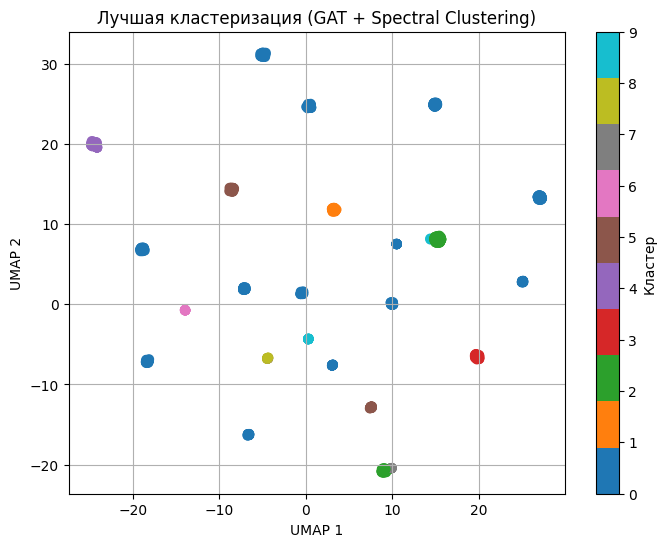

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import faiss
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

# --- Подготовка данных ---
df_transformed_filled = df_transformed.copy()  # предполагается, что df_transformed уже определён

ids = df_transformed_filled['card_id'].values
features = df_transformed_filled.drop(columns='card_id').values.astype(np.float32)
x = torch.tensor(features, dtype=torch.float)

# --- PCA перед построением графа ---
pca = PCA(n_components=50)
features_reduced = pca.fit_transform(features)

# --- Функция построения kNN графа через FAISS ---
def build_knn_graph(features_np, k=10):
    index = faiss.IndexFlatL2(features_np.shape[1])
    index.add(features_np)
    distances, neighbors = index.search(features_np, k + 1)
    edge_index = []
    for i in range(features_np.shape[0]):
        for j in neighbors[i][1:]:  # exclude self
            edge_index.append([i, j])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    return edge_index

edge_index = build_knn_graph(features_reduced, k=10)
data = Data(x=x, edge_index=edge_index)

# --- Класс энкодера GAT ---
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(in_channels, 2 * out_channels, heads=2, dropout=dropout)
        self.conv2 = GATConv(2 * out_channels * 2, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# --- Основной цикл перебора гиперпараметров ---
best_score = float('-inf')  # максимизируем Silhouette Score
best_params = {}
best_labels = None
best_embedding = None

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

for embedding_dim in [32, 64, 128]:
    for dropout_rate in [0.2, 0.3, 0.4]:
        for n_clusters in [3, 5, 7, 10]:
            print(f"\n➡️ Testing: dim={embedding_dim}, dropout={dropout_rate}, n_clusters={n_clusters}")

            model = GATEncoder(in_channels=features.shape[1], out_channels=embedding_dim, dropout=dropout_rate).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

            model.train()
            for epoch in range(100):
                optimizer.zero_grad()
                z = model(data.x, data.edge_index)
                loss = torch.norm(z, p=2)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                z = model(data.x, data.edge_index)
            z_np = z.cpu().numpy()

            # --- Spectral Clustering ---
            clusterer = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=10, random_state=42)
            labels = clusterer.fit_predict(z_np)

            if len(set(labels)) >= 3:
                silhouette = silhouette_score(z_np, labels)
                ch_score = calinski_harabasz_score(z_np, labels)
                db_score = davies_bouldin_score(z_np, labels)

                print(f"✅ Silhouette Score: {silhouette:.4f}")
                print(f"📈 Calinski-Harabasz Index: {ch_score:.2f}")
                print(f"📉 Davies-Bouldin Index: {db_score:.4f}")

                if silhouette > best_score:
                    best_score = silhouette
                    best_params = {
                        "embedding_dim": embedding_dim,
                        "dropout": dropout_rate,
                        "n_clusters": n_clusters,
                        "Silhouette": silhouette,
                        "Calinski-Harabasz": ch_score,
                        "Davies-Bouldin": db_score
                    }
                    best_labels = labels
                    best_embedding = z_np
            else:
                print("❌ Недостаточно кластеров для оценки (меньше 3)")

print("\n🏆 ЛУЧШИЕ ПАРАМЕТРЫ (по максимальному Silhouette Score):")
print(best_params)

# --- Сохраняем кластеризацию ---
cluster_df = pd.DataFrame({
    "card_id": ids,
    "cluster": best_labels
})

# --- Визуализация с UMAP ---
z_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(best_embedding)
plt.figure(figsize=(8, 6))
plt.scatter(z_umap[:, 0], z_umap[:, 1], c=best_labels, cmap='tab10', s=40)
plt.title("Лучшая кластеризация (GAT + Spectral Clustering)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.colorbar(label='Кластер')
plt.show()


In [ ]:
print(cluster_df['cluster'].value_counts())

cluster
0    1703
4     261
6      11
3      10
1       6
5       5
2       4
Name: count, dtype: int64


In [ ]:
mcc_dict = {
    3000: "United Airlines (Airlines)",
    4111: "Local and Suburban Commuter Passenger Transportation, Including Ferries",
    4814: "Telecommunication Services",
    4900: "Utilities—Electric, Gas, Water, and Sanitary",
    5122: "Drugs, Drug Proprietaries, and Druggist Sundries",
    5200: "Home Supply Warehouse Stores",
    5211: "Lumber and Building Materials Stores",
    5310: "Discount Stores",
    5311: "Department Stores",
    5399: "Miscellaneous General Merchandise",
    5942: "Book Stores",
    5945: "Hobby, Toy, and Game Stores",
    7011: "Hotels, Motels, and Resorts",
    7230: "Beauty and Barber Shops",
    7513: "Truck and Utility Trailer Rentals",
    7531: "Automotive Body Repair Shops",
    8011: "Doctors and Physicians",
    8111: "Legal Services",
    8999: "Professional Services (Not Elsewhere Classified)",
    9311: "Tax Payments"
}

# Map MCC codes to real names
df_sample['merchant_name'] = df_sample['merchant_mcc'].map(mcc_dict)